In [1]:
__author__="Xun Xun, Tulika, Lasya"
__email__='XSHI055@uottawa.ca, tshuk055@uottawa.ca, lbhas087@uottawa.ca'
__studentNumber__="7260750, 300201850, 300188682 "
 

import pandas as pd  
import re
import regex as re
import wordcloud
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from collections import Counter
from numpy.random import default_rng
import spacy
from nltk.corpus import gutenberg
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix,classification_report
from scipy.sparse import csr_matrix
from sklearn.preprocessing import FunctionTransformer
from sklearn import metrics 
from sklearn.base import TransformerMixin,BaseEstimator
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

from sklearn.metrics import accuracy_score 
from sklearn.neighbors import KNeighborsClassifier
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lasya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# download gutenberg to access the digital text books
nltk.download('gutenberg')

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\lasya\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


True

### Data

### Function to return partitioned book as a dataframe with 200 rows , each row containing 100 words 
####  1) We use the word_tokenize package from nltk to tokenize the package 
####  2) Using a while loop, we partition the book until the end of passage : 
* We grab 100 of the next token at a time 
* Using regex, we then calculate the number of tokens (n) out of the 100 that are not words but rather punctuations etc. 
* However, it is possible that the next(n) tokens also have some punctuations. So we look ahead and once again we calculate the number of tokens(n2) that are not words 
* We repeat this to get the index (100+n+n2+..) that would allow for 100 words in the passage. 
* This passage is then added onto the BookDf dataframe. 
* We repeat this process from the previous index counter. 

#### 3) If the dataframe has less than 200 rows, this means that there were not enough number of words in the book (<20000) for 200 partitions of 100 words each. This function will still return a dataframe back but gives a warning. 
#### 4) If the total length has greater than 200 rows, we used numpy's random number generator to get200  random non-repeating numbers between 0 and max number of book rows. We then return this book back to the user. 

In [3]:
def returnLabeledBook(text, bookName):
    Counter=0
    doc=word_tokenize(text)
    BookDf=pd.DataFrame(columns={'passage'})
    while((Counter+101)<len(doc)):
        
        tempdoc=" ".join(str(item) for item in doc[Counter:100+Counter])

        lengthOfNonWords=len(re.findall(r'\W\s+',tempdoc)) ## length of anything that is not a word or punctuation in the first 100 tokens
        ## i.e if there are 20 tokens that are punctuations out of 100, we should add another 20 tokens
        if((100+Counter+lengthOfNonWords)<len(doc)):
            # we do additional check to see how many punctuations are there in these additional tokens
            additionalWord=" ".join(str(item) for item in doc[100+Counter:100+Counter+lengthOfNonWords])
            lengthofNonwordsInAdditional=len(re.findall(r'\W\s+',additionalWord))
            if((100+Counter+lengthOfNonWords+lengthofNonwordsInAdditional)<len(doc)):
                
                asjustedDoc=" ".join(str(item) for item in doc[Counter:100+Counter+lengthOfNonWords+lengthofNonwordsInAdditional])
                BookDf.loc[len(BookDf)]=asjustedDoc
                Counter=Counter+lengthOfNonWords+100+lengthofNonwordsInAdditional
            else:
                break
        else:
            break
    BookDf['bookName']=bookName
    if(len(BookDf)<200): ## if there is less than 200 partions 
        print('Warning: The book has less than 20000 words and can not be split into a passage of 200 parts of 100 words.')
        return BookDf
    else:
        rng=default_rng() 
        numbers=rng.choice(len(BookDf),size=200,replace=False)
        print('We have succesfully partioned your book '+bookName+' into 200 random partitions of 100 words each. \n')
        print('Please note that there was a total of '+str(len(BookDf))+' partitions available, and the dataframe index represents the ordered part that were taken out. ')
        return BookDf.iloc[numbers] 

In [4]:

df1=pd.DataFrame()
 
df1= returnLabeledBook(nltk.corpus.gutenberg.raw('chesterton-thursday.txt'),'chesterton-thursday')
df1=df1.append(returnLabeledBook(nltk.corpus.gutenberg.raw('carroll-alice.txt'), 'carroll-alice'))
df1=df1.append(returnLabeledBook(nltk.corpus.gutenberg.raw('shakespeare-hamlet.txt'), 'shakespeare-hamlet'))
df1=df1.append(returnLabeledBook(nltk.corpus.gutenberg.raw('bryant-stories.txt'),'bryant-stories'))
df1=df1.append(returnLabeledBook(nltk.corpus.gutenberg.raw('milton-paradise.txt'),'milton-paradise'))

We have succesfully partioned your book chesterton-thursday into 200 random partitions of 100 words each. 

Please note that there was a total of 587 partitions available, and the dataframe index represents the ordered part that were taken out. 
We have succesfully partioned your book carroll-alice into 200 random partitions of 100 words each. 

Please note that there was a total of 274 partitions available, and the dataframe index represents the ordered part that were taken out. 
We have succesfully partioned your book shakespeare-hamlet into 200 random partitions of 100 words each. 

Please note that there was a total of 303 partitions available, and the dataframe index represents the ordered part that were taken out. 
We have succesfully partioned your book bryant-stories into 200 random partitions of 100 words each. 

Please note that there was a total of 468 partitions available, and the dataframe index represents the ordered part that were taken out. 
We have succesfully partione

In [5]:
df1

passage             bookName
204  no more words . His name -- '' Syme half rose ...  chesterton-thursday
291  to make it up ? '' The Professor made no answe...  chesterton-thursday
42   . `` The pate de foie gras is not good here , ...  chesterton-thursday
211  an unobtrusive earthquake . `` Leave it as it ...  chesterton-thursday
411  as the peasant belaboured his horse . The leve...  chesterton-thursday
..                                                 ...                  ...
193  The universal Maker we may praise ; Who justly...      milton-paradise
45   as when the sun new-risen Looks through the ho...      milton-paradise
312  far Exceeded human ; and his wary speech Thus ...      milton-paradise
637  his high throne ; which , under state Of riche...      milton-paradise
573  herself she pleasingly began . O sovran , virt...      milton-paradise

[1000 rows x 2 columns]

In [6]:
df1['bookName'].value_counts()

bryant-stories         200
carroll-alice          200
chesterton-thursday    200
shakespeare-hamlet     200
milton-paradise        200
Name: bookName, dtype: int64

### Please make sure book.xlsx is in the proper location and change following path to correspond to the file location. 
* Using the returnLabeledBook would generate a different combination of training/testing dataset each time. This could impact the analysis results. 
*  In order to retain consistent results each time the notebook is rerun, we are loading the data set from books.xlsx excel file. 
*  If there is an error in loading data from this excel, then different results may not match he documentation due to stochastic randomness in grouping the training/testing set.

In [7]:
df1 = pd.read_excel(r'books.xlsx')

# Data Preprocessing and cleansing: 
### Getting rid of the punctuations and Spacy Lemmatization 


*  Our choice of Spacy libary was motivated by the fact that it can perform tokenization in 0.2 milliseconds compared to nltk's 4 milliseconds.
* We are performing a lemmatization in the below code. It is a process of converting many different forms to it's root word. For example, words such as building, built, build etc will be converted  to its base form or lemma 'build', based on the context of the words surrounding it. 
* The nlp pipeline created using Spacy will automatically perform the tokenization, parsing and tagging processes for us.
* We have reran this code without these preprocessing step which lead to lower accuracy. 
* We are not removing stopwords during preprocessing because these features assists in adding context to the classification. Because our data contains past century books such as Shakespeare's Hamlet, the common language are different then than modern books. Thhese stopwords could serve as key feature to help distinguish these differences. Removing them could potentially reduce the accuracy of the model in classifying such books.


In [8]:
def return_split(passage):
  return (re.sub(r'[^\w\s]', '', str(passage).lower().strip()))

In [9]:
df1['passage']=df1['passage'].apply(return_split)

In [10]:
nlp=spacy.load('en_core_web_sm')

In [11]:
def lemmatization(x):
  X_list=[]
  for token in nlp(x):
    lemma=token.text
    X_list.append(lemma)
  return " ".join(X_list)

In [12]:
df1['passage']=df1['passage'].apply(lemmatization)

### Performing the Training/Testing Data Split on the book partitions dataframe

In [13]:
x=df1['passage']

In [14]:
y=df1['bookName']


In [15]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,train_size=0.7,random_state=42) ## random state 42 for rerunning purposes

# Feature Engineering:  
As a first choice, we are using TF-IDF to transform our X (Passages) into vectors 
* TF-IDF is a vectorization algorithm which is used to represent textual data in numerical vectors . It gives weights to the words depending on their frequency. 
* Compared to bag of words, TF-IDF also calculates the inverse document frequency, which will factor in the frequency of the word to occur in all documents. This will take out very commonly used words. 
* The 'Fit' is used to identify the vocabulary and frequency whereas the 'Transform' is used for conversion to a vector.

In [16]:
vec = TfidfVectorizer(binary=True, use_idf=True)
tfidf_train_data = vec.fit_transform(x_train) 
tfidf_test_data = vec.transform(x_test)

# Modelling 

# SVC Algorithm with TF-IDF
The purpose of a Linear SVC i.e Support Vector Classifier is to return a  hyperplane that seperates the data into groups. 
## Hyper parameter tuning 
* We are performing hyper parameter tuning on:
 * C: also known as the penalty parameter, this parameter controls the width of the error margin. The higher the value of C, the lesser the width of the margin. Too wide of the margin can lead to underfitting and too narrow of the margin can lead to overfitting . 
 * type of loss  

## Grid search and 10 fold cross validation 
* We use a grid search to identify the best combination of the hyper parameters that provides the best accuracy results 
* During this grid search we try each of the parameter combination on a 10-fold cross validation 
* In cross validation we are splitting the training data again into 10 seperate parts, and holding one part out for testing each time. 

In [17]:
SVCparameters = {
  'C':[1,2,3,4,5,6,7,8,9,10],
  'loss': ['squared_hinge','hinge'], 
  }
clf=LinearSVC(random_state=101) 
grid_search=GridSearchCV(clf,SVCparameters,cv=10,return_train_score=True,scoring='accuracy')
grid_search.fit(tfidf_train_data,y_train)

GridSearchCV(cv=10, estimator=LinearSVC(random_state=101),
             param_grid={'C': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'loss': ['squared_hinge', 'hinge']},
             return_train_score=True, scoring='accuracy')

#### The following function concatenates the grid_search results into a more readable dataframe with the below results 
 * test scores of CV1,CV2,CV3,CV4,CV5,CV6,CV7,CV8,CV9,CV10
 * train scores of CV1,CV2,CV3,CV4,CV5,CV6,CV7,CV8,CV9,CV10
 * average train score from 10 fold cross validation
 * average test score from 10 fold cross validation
 * The corresponding parameter combinations for these features
 

In [18]:
def gridsearchResultstoDf(grid_search):
    results=pd.DataFrame(columns={'mean test score','mean train score','param', 'CV1 train loss','CV1 test loss', 'CV2 train loss','CV2 test loss', 'CV3 train loss','CV3 test loss',  'CV4 train loss','CV4 test loss', 'CV5 trainloss','CV5 test loss','CV6 train loss','CV6 test loss','CV7 train loss','CV7 test loss','CV8 train loss','CV8 test loss','CV9 train loss','CV9 test loss','CV10 train loss','CV10 test loss' })
    results=results[['mean test score','mean train score','param' , 'CV1 train loss','CV1 test loss', 'CV2 train loss','CV2 test loss', 'CV3 train loss','CV3 test loss',  'CV4 train loss','CV4 test loss', 'CV5 trainloss','CV5 test loss','CV6 train loss','CV6 test loss','CV7 train loss','CV7 test loss','CV8 train loss','CV8 test loss','CV9 train loss','CV9 test loss','CV10 train loss','CV10 test loss' ]]
    for mean_test_score,mean_train_score,params,testsplit0,testsplit1,testsplit2,testsplit3,testsplit4,testsplit5,testsplit6,testsplit7,testsplit8,testsplit9,trainsplit0,trainsplit1,trainsplit2,trainsplit3,trainsplit4,trainsplit5,trainsplit6,trainsplit7,trainsplit8,trainsplit9 in zip(grid_search.cv_results_["mean_test_score"],grid_search.cv_results_["mean_train_score"],grid_search.cv_results_["params"],grid_search.cv_results_["split0_test_score"],grid_search.cv_results_["split1_test_score"],grid_search.cv_results_["split2_test_score"],grid_search.cv_results_["split3_test_score"],grid_search.cv_results_["split4_test_score"],grid_search.cv_results_["split5_test_score"],grid_search.cv_results_["split6_test_score"],grid_search.cv_results_["split7_test_score"],grid_search.cv_results_["split8_test_score"],grid_search.cv_results_["split9_test_score"],grid_search.cv_results_["split0_train_score"],grid_search.cv_results_["split1_train_score"],grid_search.cv_results_["split2_train_score"],grid_search.cv_results_["split3_train_score"],grid_search.cv_results_["split4_train_score"],grid_search.cv_results_["split5_train_score"],grid_search.cv_results_["split6_train_score"],grid_search.cv_results_["split7_train_score"],grid_search.cv_results_["split8_train_score"],grid_search.cv_results_["split9_train_score"]):
        z=[mean_test_score,mean_train_score,params ,trainsplit0,testsplit0,trainsplit1,testsplit1,trainsplit2,testsplit2,trainsplit3,testsplit3,trainsplit4,testsplit4,trainsplit5,testsplit5,trainsplit6,testsplit6,trainsplit7,testsplit7,trainsplit8,testsplit8,trainsplit9,testsplit9]
        results.loc[len(results)]=z
    return results

#### Grid search results returned for  Tf-idf and SVC algorithm.
All results are sorted by the worse to best test scores averaged from the 10-Fold Cross Validation. In some instances, multiple records can have equal (best) score. In such case, we are selecting the first best combination we come across, because any parameter combinations with yield the same test scores. 

In [19]:
results=gridsearchResultstoDf(grid_search)

In [20]:
results.sort_values(by='mean test score')

mean test score  mean train score                               param  \
0          0.985714               1.0   {'C': 1, 'loss': 'squared_hinge'}   
17         0.987143               1.0           {'C': 9, 'loss': 'hinge'}   
16         0.987143               1.0   {'C': 9, 'loss': 'squared_hinge'}   
15         0.987143               1.0           {'C': 8, 'loss': 'hinge'}   
14         0.987143               1.0   {'C': 8, 'loss': 'squared_hinge'}   
13         0.987143               1.0           {'C': 7, 'loss': 'hinge'}   
12         0.987143               1.0   {'C': 7, 'loss': 'squared_hinge'}   
11         0.987143               1.0           {'C': 6, 'loss': 'hinge'}   
10         0.987143               1.0   {'C': 6, 'loss': 'squared_hinge'}   
9          0.987143               1.0           {'C': 5, 'loss': 'hinge'}   
8          0.987143               1.0   {'C': 5, 'loss': 'squared_hinge'}   
7          0.987143               1.0           {'C': 4, 'loss': 'hinge'}   
5          0.987143               1.0           {'C': 3, 'loss': 'hinge'}   
3          0.987143               1.0           {'C': 2, 'loss': 'hinge'}   
2          0.987143               1.0   {'C': 2, 'loss': 'squared_hinge'}   
1          0.987143               1.0           {'C': 1, 'loss': 'hinge'}   
18         0.987143               1.0  {'C': 10, 'loss': 'squared_hinge'}   
19         0.987143               1.0          {'C': 10, 'loss': 'hinge'}   
6          0.988571               1.0   {'C': 4, 'loss': 'squared_hinge'}   
4          0.988571               1.0   {'C': 3, 'loss': 'squared_hinge'}   

    CV1 train loss  CV1 test loss  CV2 train loss  CV2 test loss  \
0              1.0       0.971429             1.0            1.0   
17             1.0       0.985714             1.0            1.0   
16             1.0       0.985714             1.0            1.0   
15             1.0       0.985714             1.0            1.0   
14             1.0       0.985714             1.0            1.0   
13             1.0       0.985714             1.0            1.0   
12             1.0       0.985714             1.0            1.0   
11             1.0       0.985714             1.0            1.0   
10             1.0       0.985714             1.0            1.0   
9              1.0       0.985714             1.0            1.0   
8              1.0       0.985714             1.0            1.0   
7              1.0       0.985714             1.0            1.0   
5              1.0       0.985714             1.0            1.0   
3              1.0       0.985714             1.0            1.0   
2              1.0       0.985714             1.0            1.0   
1              1.0       0.985714             1.0            1.0   
18             1.0       0.985714             1.0            1.0   
19             1.0       0.985714             1.0            1.0   
6              1.0       0.985714             1.0            1.0   
4              1.0       0.985714             1.0            1.0   

    CV3 train loss  CV3 test loss  CV4 train loss  ...  CV6 train loss  \
0              1.0       0.985714             1.0  ...             1.0   
17             1.0       0.985714             1.0  ...             1.0   
16             1.0       0.985714             1.0  ...             1.0   
15             1.0       0.985714             1.0  ...             1.0   
14             1.0       0.985714             1.0  ...             1.0   
13             1.0       0.985714             1.0  ...             1.0   
12             1.0       0.985714             1.0  ...             1.0   
11             1.0       0.985714             1.0  ...             1.0   
10             1.0       0.985714             1.0  ...             1.0   
9              1.0       0.985714             1.0  ...             1.0   
8              1.0       0.985714             1.0  ...             1.0   
7              1.0       0.985714             1.0  ...             1.

In [21]:
  results[results['mean test score']==results['mean test score'].max()].iloc[0]['param']

{'C': 3, 'loss': 'squared_hinge'}

In [22]:
temp_tree_cv_results=results
temp_tree_cv_results[['C','loss']]=temp_tree_cv_results['param'].apply(pd.Series)
temp_tree_cv_results['test sdv']=temp_tree_cv_results[['CV1 test loss','CV2 test loss','CV3 test loss','CV4 test loss','CV5 test loss','CV6 test loss','CV7 test loss','CV9 test loss','CV10 test loss']].std(axis=1)
temp_tree_cv_results['train sdv']=temp_tree_cv_results[['CV1 train loss','CV2 train loss','CV3 train loss','CV4 train loss','CV5 trainloss','CV6 train loss','CV7 train loss','CV9 train loss','CV10 train loss']].std(axis=1)

## Learning Curve:
These are graphic representations for selecting the best parameter combination. We look to see whether increasing a parameter value will yield overfitting. 


### Bias and Variance Tradeoff 
### Learning curve for different values of parameter C at using a Hinge Loss
* From the plotted graph, we can see that the model is neither an overfit nor an underfit for the changes in the parameter.
* The average train and test scores are almost overlapping for all ranges of C and there is very little standard deviation of scores (which is not visible in the graph). 
* The consistent high average score across 10 CV along with very low std means that using any value of C in a range of [0-10], with hingeloss, in a SVM method will yield a model with low bias and low variance. 


Text(0.5, 1.0, 'Learning Curves from Cross validation of SVC/Tf-idf (loss=hinge)')

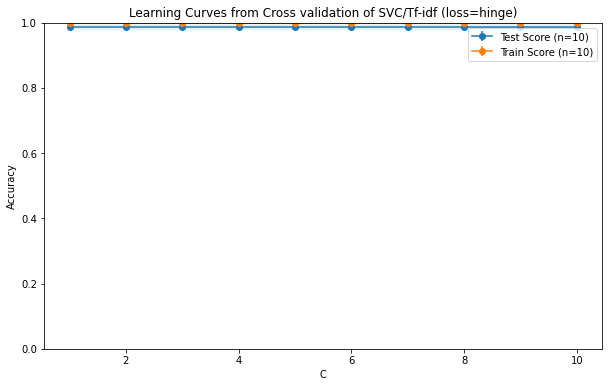

In [23]:

plt.figure(figsize=(10,6))
temp_tree_cv_results.sort_values(by='C',inplace=True)
resultsSVC=temp_tree_cv_results[temp_tree_cv_results['loss']=='hinge']
plt.fill_between(resultsSVC['C'],resultsSVC['mean test score']-resultsSVC['test sdv'],resultsSVC['mean test score']+resultsSVC['test sdv'],alpha=0.1)
plt.fill_between(resultsSVC['C'],resultsSVC['mean train score']-resultsSVC['train sdv'],resultsSVC['mean train score']+resultsSVC['train sdv'],alpha=0.1)
plt.errorbar(resultsSVC['C'],resultsSVC['mean test score'],resultsSVC['test sdv'],label='Test Score (n=10)',fmt='-o')
plt.errorbar(resultsSVC['C'],resultsSVC['mean train score'],resultsSVC['train sdv'],label='Train Score (n=10)',fmt='-o')
plt.ylabel('Accuracy')
plt.xlabel('C')
plt.legend()
plt.ylim(0,1)
plt.title('Learning Curves from Cross validation of SVC/Tf-idf (loss=hinge)')

### Learning curve for different parameters of C at using a Squared Hinge Loss
* This graph has very similar results compared to hinge loss. There is no significant sign of overfitting 
* The average train and test scores are almost overlapping for all ranges of C and there is very little standard deviation of scores (which is not visible in the graph). 
* The consistent high average score across 10 CV along with very low std means that using any value of C in a range of [0-10], with squared hinge loss, in a SVM method will yield a model with low bias and low variance. 

* Using Squared Hinge or Hinge will not impose a huge difference in prediction accuracy in the final model. 

Text(0.5, 1.0, 'Learning Curves from Cross validation of SVC/Tf-idf (loss=squared_hinge)')

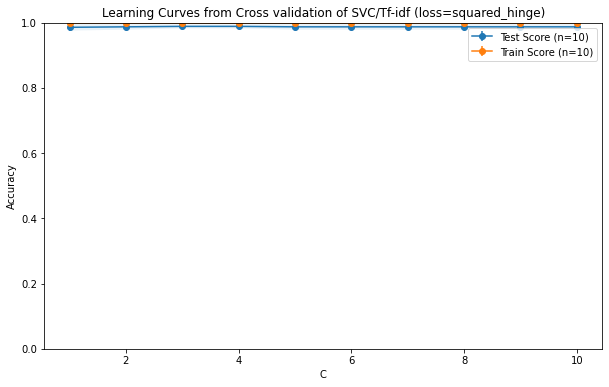

In [24]:
plt.figure(figsize=(10,6))
temp_tree_cv_results.sort_values(by='C',inplace=True)
resultsSVC=temp_tree_cv_results[temp_tree_cv_results['loss']=='squared_hinge']
plt.fill_between(resultsSVC['C'],resultsSVC['mean test score']-resultsSVC['test sdv'],resultsSVC['mean test score']+resultsSVC['test sdv'],alpha=0.1)
plt.fill_between(resultsSVC['C'],resultsSVC['mean train score']-resultsSVC['train sdv'],resultsSVC['mean train score']+resultsSVC['train sdv'],alpha=0.1)
plt.errorbar(resultsSVC['C'],resultsSVC['mean test score'],resultsSVC['test sdv'],label='Test Score (n=10)',fmt='-o')
plt.errorbar(resultsSVC['C'],resultsSVC['mean train score'],resultsSVC['train sdv'],label='Train Score (n=10)',fmt='-o')
plt.ylabel('Accuracy')
plt.xlabel('C')
plt.legend()
plt.ylim(0,1)
plt.title('Learning Curves from Cross validation of SVC/Tf-idf (loss=squared_hinge)')

## Scoring:
### Implementation of the Tf-idf and SVC algorithm with the optimal hyper parameters determined from grid search on the test data.
* We train the model using the vectorized X train data and Y train. We predict the results using the vectorized X test data.
* This tuned model will be used to predict the true test/holdout data. 

In [25]:
clf=LinearSVC(C=3,loss='squared_hinge')
clf.fit(tfidf_train_data,y_train)
predictions= clf.predict(tfidf_test_data)    

# Testing Results : 
#### Confusion matrix and Classification report for the Tf-idf/SVC(C=3,loss='squared_hinge') classifier's performance. 

In [26]:
 print(confusion_matrix(y_test,predictions)) 
    

[[51  0  1  1  0]
 [ 0 71  0  0  0]
 [ 1  0 54  0  0]
 [ 0  0  0 64  0]
 [ 0  0  0  0 57]]


In [27]:
 print(classification_report(y_test,predictions))

                     precision    recall  f1-score   support

     bryant-stories       0.98      0.96      0.97        53
      carroll-alice       1.00      1.00      1.00        71
chesterton-thursday       0.98      0.98      0.98        55
    milton-paradise       0.98      1.00      0.99        64
 shakespeare-hamlet       1.00      1.00      1.00        57

           accuracy                           0.99       300
          macro avg       0.99      0.99      0.99       300
       weighted avg       0.99      0.99      0.99       300



#### The results are great! An accuracy of 0.99 and F1 score of 1.0. Let's plot these using ROC. 

In [28]:
def plot_ROC(y_test,predictions,title):
  y_test_labelled = label_binarize(y_test, classes=['chesterton-thursday', 'carroll-alice', 'shakespeare-hamlet', 'bryant-stories', 'milton-paradise'])
  predictions_labelled = label_binarize(predictions, classes=['chesterton-thursday', 'carroll-alice', 'shakespeare-hamlet', 'bryant-stories', 'milton-paradise'])
  classes=['chesterton-thursday', 'carroll-alice', 'shakespeare-hamlet', 'bryant-stories', 'milton-paradise']
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(5):
      fpr[i], tpr[i], _ = roc_curve(y_test_labelled[:, i], predictions_labelled[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(y_test_labelled.ravel(), predictions_labelled.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
  plt.figure(figsize=(10,6))
  for i in range(5):  
      plt.plot(fpr[i], tpr[i], label=str(classes[i])+': (area = %0.2f)' % roc_auc[i])
      plt.plot([0, 1], [0, 1], 'k--')
      plt.xlim([0.0, 1.0])
      plt.ylim([0.0, 1.05])
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title('ROC on Test Data'+str(title))
      plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left') 

### ROC Curve:
A Receiver Operating Characteristic curve is a graph that shows the performance of a classification model for different classes based on the true positive and false positive rates.
* The areas under the curve is high (actually perfect with 1.0) for Shakespeare-Hamlet and Milton-paradise, demonstrating that the model can always correctly classify 16th century classics. The area under the curve is a lower for other modern books ( chesterton-thursday with 0.99 and byrant-stories with 0,98), showing that it can occasionally misclassify modern writing styles.

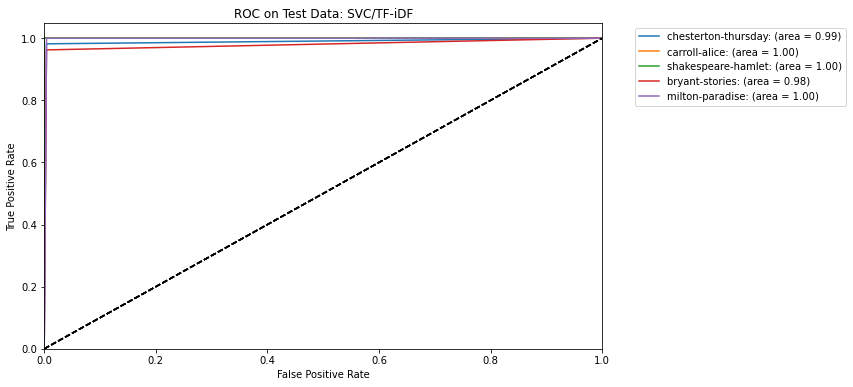

In [29]:
plot_ROC(y_test,predictions,': SVC/TF-iDF')

In [30]:
totalListoferrors=pd.DataFrame(columns=['input','predictions','labels'])
for input, prediction, label in zip(x_test, predictions, y_test):
    if prediction != label:
        listOfErrors=[input,prediction,label]
        totalListoferrors.loc[len(totalListoferrors)]=listOfErrors

# Error Analysis:
Error Analysis is used to determine the type of errors made by the model and identify the causes for such a misclassification, in order to define an approach to fix them in the future.

The following is the list of misclassified labels

In [31]:
totalListoferrors.groupby(by=['predictions','labels']).count()

input
predictions         labels                    
bryant-stories      chesterton-thursday      1
chesterton-thursday bryant-stories           1
milton-paradise     bryant-stories           1

##### Wordclouds are useful for visualization the type of words used in the passages that were misclassified to identify errors  
#### The Visualizations shown below are done using word clouds on the 3 mistakes made by the classifier.
A passages from chestorton-thursday was misclassified as bryant-stories and two passages from bryant-stories were misclassified as chesterton-thursday and milton-paradise.
* Reason 1: In the following visualizations, some of the high frequency words in the passages seem to be stopwords. Since stop words are not unique to a writing style, this could have lead to a misclassification. (We haven't removed stopwords as they could serve as keywords in 16th century classics such as Hamlet)
* Reason 2: The specific passage might have words which are not repeated elsewhere throughout the actual book, but could be present in the predicted book that it is classified as. This could be causing the misclassification.
Ex. the word 'giantmaidens' from chesterton-thursday passage could be only present in that passage of the book, but there is a chance that the word is available in bryant-stories. 

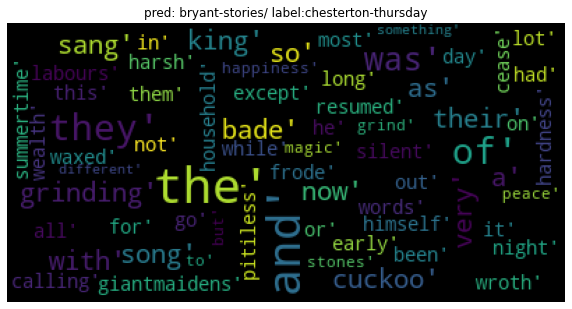

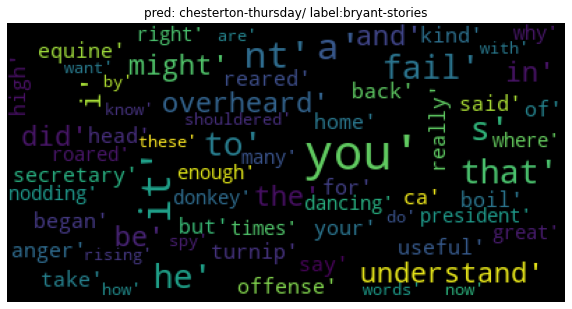

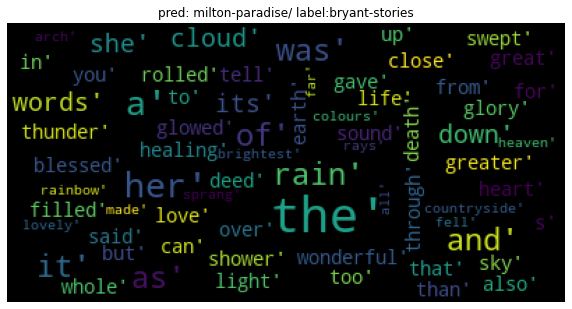

In [32]:
wordc = wordcloud.WordCloud(background_color='black', max_words=100, 
                         max_font_size=35)
wc = wordc.generate(str(nltk.tokenize.word_tokenize(totalListoferrors['input'].iloc[0])))
fig = plt.figure(num=1,figsize=(10,6))
plt.axis('off')
plt.imshow(wc, cmap=None)
plt.title('pred: bryant-stories/ label:chesterton-thursday'	)
plt.show()

wc = wordc.generate(str(nltk.tokenize.word_tokenize(totalListoferrors['input'].iloc[1])))
fig = plt.figure(num=1,figsize=(10,6))
plt.axis('off')
plt.imshow(wc, cmap=None)
plt.title('pred: chesterton-thursday/ label:bryant-stories')
plt.show()

wc = wordc.generate(str(nltk.tokenize.word_tokenize(totalListoferrors['input'].iloc[2])))
fig = plt.figure(num=1,figsize=(10,6))
plt.axis('off')
plt.imshow(wc, cmap=None)
plt.title('pred: milton-paradise/ label:bryant-stories')
plt.show()


#### Unigrams and Bigrams:
The following function shows the most frequently occuring words - alone(unigram) or together in pairs of two(bigrams).


In [33]:

def plot_unigram_bigram(corpus_test_highesterror,pred_title):
  lst_tokens = nltk.tokenize.word_tokenize(corpus_test_highesterror)
  dic_words_freq = nltk.FreqDist(lst_tokens)
  fig, ax = plt.subplots(nrows=1, ncols=2)
  fig.suptitle("Most frequent words in pred:"+pred_title, fontsize=15)
  dtf_uni = pd.DataFrame(dic_words_freq.most_common(), 
                        columns=["Word","Freq"])
  dtf_uni.set_index("Word").iloc[:10,:].sort_values(by="Freq").plot(
                    kind="barh", title="Unigrams", ax=ax[0], 
                    legend=False).grid(axis='x')
  ax[0].set(ylabel=None)

      
  ## bigrams
  dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, 2))
  dtf_bi = pd.DataFrame(dic_words_freq.most_common(), 
                        columns=["Word","Freq"])
  dtf_bi["Word"] = dtf_bi["Word"].apply(lambda x: " ".join(
                    string for string in x) )
  dtf_bi.set_index("Word").iloc[:10,:].sort_values(by="Freq").plot(
                    kind="barh", title="Bigrams", ax=ax[1],
                    legend=False).grid(axis='x')
  ax[1].set(ylabel=None)
  plt.subplots_adjust(wspace=0.6,hspace=1,right=1)
  plt.show()
  fig.tight_layout(pad=10.0)

#### From the plotted graph, we can see that the most frequently occuring unigrams and bigrams are stopwords and their combinations, which gives further insight for the resulting misclassification.

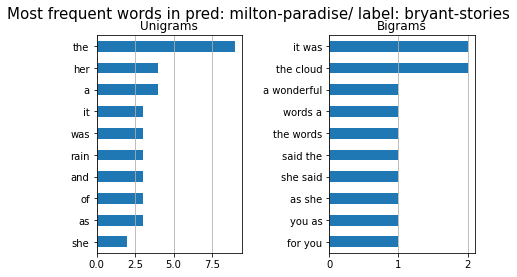

<ipython-input-33-6cfcc1756c68>:26: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout(pad=10.0)


In [34]:
temp=corpus_test_highesterror=totalListoferrors[(totalListoferrors['predictions']=='milton-paradise')]['input'].values[0]
plot_unigram_bigram(temp,' milton-paradise/ label: bryant-stories')



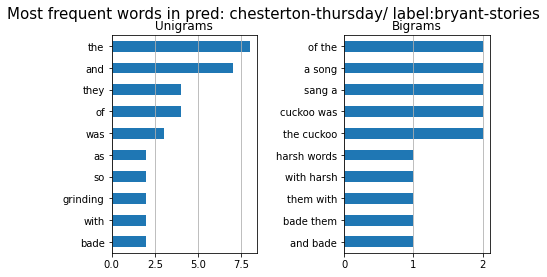

<ipython-input-33-6cfcc1756c68>:26: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout(pad=10.0)


In [35]:

temp=corpus_test_highesterror=totalListoferrors[(totalListoferrors['predictions']=='chesterton-thursday')]['input'].values[0] 
plot_unigram_bigram(temp,' chesterton-thursday/ label:bryant-stories')



### Summary of results from TF-IDF/SVC
* Grid search performed has shown that the optimal hyper parameters values is C=3 and loss ='squared_hinge'.
* From training/CV: There does not seem to be any overfitting from the cross validation data ( test accuracy and train accuracy very similar during cross validation). The visualized learning curve graph also justifies how the model is well-fit for the given data.
* For the actual testing data: majority of the values of the confusion matrix is in the diagonal, and our prediction can predict the label correctly 99% of the time for new data! The ROC curve also shows how 16th century classics could be classified better than the modern style writings.
* Error analysis: The visualizations showing the word clouds and unigrams/bigrams show the potential influence of stopwords on the misclassification.
* The SVC model with TF-IDF vectorization is pretty good! 

--------------------------------------------------------------------------------------------------------------------------------

# KNN  TF-IDF
# Modelling


KNN  is a supervised learning algorithm which operates on minimalizing the distance between features for classification. 


### Hyper parameter tuning using grid-search with 10 fold cross validation
* We are performing the hyper parameter tuning on:
 * type of distance monitoring (p): 
    * p=1 uses manhattan_distance
    * p=2 uses euclidean_distance 
 * weights: 
    * uniform ( all points will be given equal weights)
    * distance (points will be given weights that are inverse to the distance)
 


In [36]:
KNNparameters = {
  'p':[1,2],
  'weights': ['uniform','distance'], 
  }
clf= KNeighborsClassifier(n_neighbors=3) 
grid_search=GridSearchCV(clf,KNNparameters,cv=10,return_train_score=True,scoring='accuracy')
grid_search.fit(tfidf_train_data,y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(n_neighbors=3),
             param_grid={'p': [1, 2], 'weights': ['uniform', 'distance']},
             return_train_score=True, scoring='accuracy')

#### Grid search results returned for  TF-IDF and KNN algorithm. 

Instead of showing the detailed analysis of grid search results to select best parameters (as shown with SVC and TFIDF), we can also use best_params_ with the grid search object to yield the same result.

In [37]:
grid_search.best_params_

{'p': 2, 'weights': 'distance'}

In [38]:
results=gridsearchResultstoDf(grid_search)


In [39]:

temp_tree_cv_results=results
temp_tree_cv_results[['uniform','distance']]=temp_tree_cv_results['param'].apply(pd.Series)
temp_tree_cv_results['test sdv']=temp_tree_cv_results[['CV1 test loss','CV2 test loss','CV3 test loss','CV4 test loss','CV5 test loss','CV6 test loss','CV7 test loss','CV9 test loss','CV10 test loss']].std(axis=1)
temp_tree_cv_results['train sdv']=temp_tree_cv_results[['CV1 train loss','CV2 train loss','CV3 train loss','CV4 train loss','CV5 trainloss','CV6 train loss','CV7 train loss','CV9 train loss','CV10 train loss']].std(axis=1)

### Model Bias and Variance 
* For manhattan(p=1) distance, the average mean of cross-validation test data have low accuracy (0.5) for both uniform and inverse-distance weights. But for different reasons. Uniform weights have low average training accuracy and test accuracy, indicating underfitting (high bias and low variance). While inverse-distance weights have average training accuracy much higher, it also has low test accuracy, which indicates that the model is overfitting (low bias and high variance).
* For euclidean (p=2) distance, both uniform and inverse-distance weights have high training accuracy and high test accuracy. These indicates good models that are able to generalize to new data (in cross validation). Therefore, euclidian distance should be used with either random or inverse-distance. 

(0.0, 1.0)

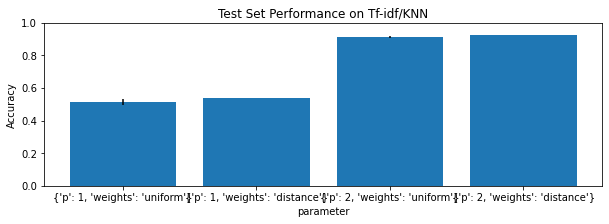

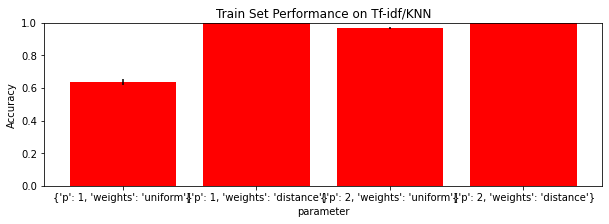

In [40]:
temp_tree_cv_results['param'].astype(str)

fig=plt.figure(figsize=(10,3))
plt.title('Test Set Performance on Tf-idf/KNN')
plt.bar(temp_tree_cv_results['param'].astype(str),temp_tree_cv_results['mean test score'],yerr=temp_tree_cv_results['train sdv'])
plt.xlabel('parameter')
plt.ylabel('Accuracy')
plt.ylim(0,1)
  
fig=plt.figure(figsize=(10,3))
plt.title('Train Set Performance on Tf-idf/KNN')
plt.bar(temp_tree_cv_results['param'].astype(str),temp_tree_cv_results['mean train score'],yerr=temp_tree_cv_results['train sdv'],color='red')
plt.rc('font', size=10) 
plt.xlabel('parameter')
plt.ylabel('Accuracy')
plt.ylim(0,1)

# Scoring:

Implementing the Tf-idf and KNN algorithm with the optimal hyper parameters determined from grid search. We train the model using the vectorized X train data and Y train. We predict the results using the vectorized X test data. This tuned model will now be predicted using the true test/holdout data.

In [41]:
clf=KNeighborsClassifier( p=2,weights='distance')
clf.fit(tfidf_train_data,y_train)
predictions= clf.predict(tfidf_test_data)    

# Testing Results : 
#### Confusion matrix and Classification report for the Tf-idf/KNN(euclidean_distance, distance-weights) classifier's performance. 

#### The confusion matrix here shows fairly good results. Most of the values are mainly in the diagonal!

In [42]:
print(confusion_matrix(y_test,predictions)) 
    
    

[[50  1  2  0  0]
 [ 0 71  0  0  0]
 [ 2 11 42  0  0]
 [ 2  1  2 59  0]
 [ 0  0  0  0 57]]


#### The classification report shows an accuracy of 0.93. This is a pretty good classifier!

In [43]:
print(classification_report(y_test,predictions))

                     precision    recall  f1-score   support

     bryant-stories       0.93      0.94      0.93        53
      carroll-alice       0.85      1.00      0.92        71
chesterton-thursday       0.91      0.76      0.83        55
    milton-paradise       1.00      0.92      0.96        64
 shakespeare-hamlet       1.00      1.00      1.00        57

           accuracy                           0.93       300
          macro avg       0.94      0.93      0.93       300
       weighted avg       0.93      0.93      0.93       300



### ROC Curve:
 The following ROC demonstrates that area under the curve are all fairly high, with the exception of chesterton-thursday. 
 This means that this classifier is having difficulty predicting for chesterton-thursday. 
 Overall these results are good!
 

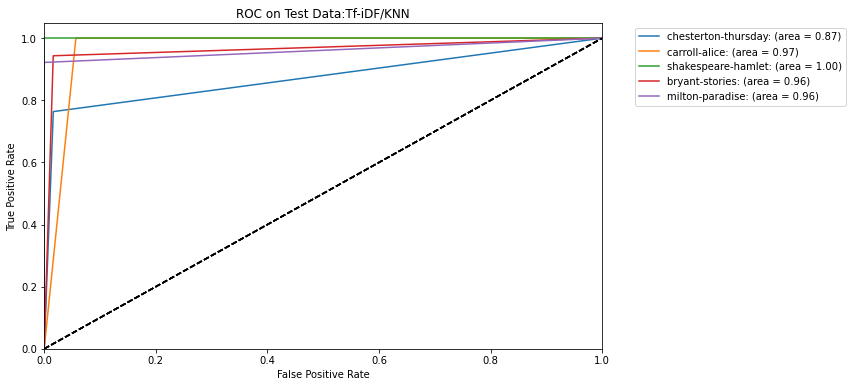

In [44]:
plot_ROC(y_test,predictions,':Tf-iDF/KNN')

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Random Forest Algorithm- TF-IDF
# Modelling 
Random forest is a supervised learning algorithm which operates on a large number of decision trees grouped together. Each individual tree returns class predictions and the class with the most votes will be selected. Since the correlation between the models is low, this algorithm is less prone to overfitting compared to decision tree.
### Hyper parameter tuning using grid-search with 10 fold cross validation
* We are performing the hyper parameter tuning on:
 * whether to use bootstrap
 * n_estimators (number of trees ): 5-500
         The number of trees is set using the n_estimators parameter which is by default set to 100. With increase in the number of trees the performance usually stabilizes, but could lead to overfitting.
* If bootstrap parameter is set to True then bootstrap samples are used. If false, training dataset is used to build the trees. 
* Note that we did not investigate other parameters such as tree depth or number of split. We used the default values of 100 and 2 for those. 


In [45]:
 RFparameters = {
  'bootstrap':['True','False'],
  'n_estimators': [5,10,50,100,250,500],
  }
clf=RandomForestClassifier(random_state=101) 
grid_searchRF=GridSearchCV(clf,RFparameters,cv=10,return_train_score=True,scoring='accuracy')
grid_searchRF.fit(tfidf_train_data,y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=20),
             param_grid={'bootstrap': ['True', 'False'],
                         'n_estimators': [5, 10, 50, 100, 250, 500]},
             return_train_score=True, scoring='accuracy')

#### Grid search results returned for  TF-IDF and Random Forest algorithm. 

Instead of showing the detailed analysis of grid search results to select best parameters (as shown with SVC and TFIDF), we can also use best_params_ with the grid search object to yield the same result.

In [46]:
results=gridsearchResultstoDf(grid_searchRF)
results.sort_values(by='mean test score')
results[results['mean test score']==results['mean test score'].max()].iloc[0]['param']
# grid_searchRF.best_params_

{'bootstrap': 'True', 'n_estimators': 500}

In [47]:
grid_searchRF.best_params_

{'bootstrap': 'True', 'n_estimators': 500}

## Learning Curve:


In [48]:
temp_tree_cv_results=results
temp_tree_cv_results[['bootstrap','n_estimators']]=temp_tree_cv_results['param'].apply(pd.Series)
temp_tree_cv_results['test sdv']=temp_tree_cv_results[['CV1 test loss','CV2 test loss','CV3 test loss','CV4 test loss','CV5 test loss','CV6 test loss','CV7 test loss','CV9 test loss','CV10 test loss']].std(axis=1)
temp_tree_cv_results['train sdv']=temp_tree_cv_results[['CV1 train loss','CV2 train loss','CV3 train loss','CV4 train loss','CV5 trainloss','CV6 train loss','CV7 train loss','CV9 train loss','CV10 train loss']].std(axis=1)

### Model Bias and Variance  
### Increasing more trees(>250) will decrease bias but increase variance !
* From the following learning curve graphs, the mean test score seems to be stabilized after 100 trees. 
* However, as we increase trees from 250 trees to 500 trees, the shaded blue area increases.This areais calculated based on the standard deviation across the 10 cross validation of models. 
* This means that while increasing the number of trees from 250 to 500 may have decreased model bias, we have increased the model variance, and may be more prone to overfitting. 
* This case is true for both with bootstrap and without bootstrap. 
* However, because the standard deviation did not flucturate greatly, we can presume that that we can use the 500 trees.

Text(0.5, 1.0, 'Learning Curves from Cross validation (bootstrap=False)')

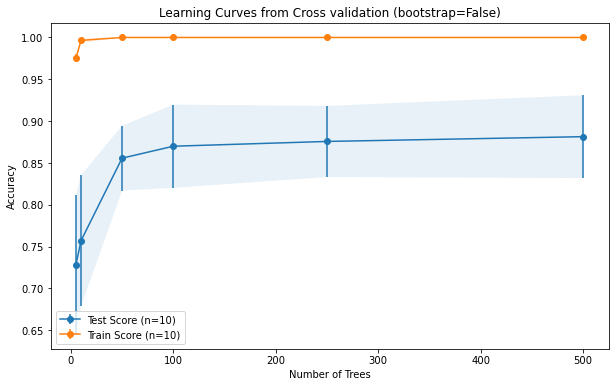

In [49]:
fig = plt.figure(num=1,figsize=(10,6))
temp_tree_cv_results.sort_values(by='n_estimators',inplace=True)
bootstrapFalse_cv_results=temp_tree_cv_results[temp_tree_cv_results['bootstrap']=='False']
plt.fill_between(bootstrapFalse_cv_results['n_estimators'],bootstrapFalse_cv_results['mean test score']-bootstrapFalse_cv_results['test sdv'],bootstrapFalse_cv_results['mean test score']+bootstrapFalse_cv_results['test sdv'],alpha=0.1)
plt.fill_between(bootstrapFalse_cv_results['n_estimators'],bootstrapFalse_cv_results['mean train score']-bootstrapFalse_cv_results['train sdv'],bootstrapFalse_cv_results['mean train score']+bootstrapFalse_cv_results['train sdv'],alpha=0.1)
plt.errorbar(temp_tree_cv_results[temp_tree_cv_results['bootstrap']=='False']['n_estimators'],temp_tree_cv_results[temp_tree_cv_results['bootstrap']=='False']['mean test score'],temp_tree_cv_results[temp_tree_cv_results['bootstrap']=='False']['test sdv'],label='Test Score (n=10)',fmt='-o')
plt.errorbar(temp_tree_cv_results[temp_tree_cv_results['bootstrap']=='False']['n_estimators'],temp_tree_cv_results[temp_tree_cv_results['bootstrap']=='False']['mean train score'],temp_tree_cv_results[temp_tree_cv_results['bootstrap']=='False']['train sdv'],label='Train Score (n=10)',fmt='-o')
plt.ylabel('Accuracy')
plt.xlabel('Number of Trees')
plt.legend()
plt.title('Learning Curves from Cross validation (bootstrap=False)')

Text(0.5, 1.0, 'Learning Curves from Cross validation (bootstrap=True)')

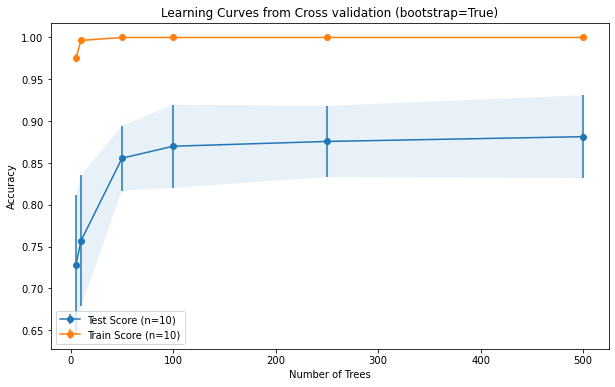

In [50]:
fig = plt.figure(num=1,figsize=(10,6))
temp_tree_cv_results.sort_values(by='n_estimators',inplace=True)
bootstrapTrue_cv_results=temp_tree_cv_results[temp_tree_cv_results['bootstrap']=='True']
plt.fill_between(bootstrapTrue_cv_results['n_estimators'],bootstrapTrue_cv_results['mean test score']-bootstrapTrue_cv_results['test sdv'],bootstrapTrue_cv_results['mean test score']+bootstrapTrue_cv_results['test sdv'],alpha=0.1)
plt.fill_between(bootstrapTrue_cv_results['n_estimators'],bootstrapTrue_cv_results['mean train score']-bootstrapTrue_cv_results['train sdv'],bootstrapTrue_cv_results['mean train score']+bootstrapTrue_cv_results['train sdv'],alpha=0.1)
plt.errorbar(temp_tree_cv_results[temp_tree_cv_results['bootstrap']=='True']['n_estimators'],temp_tree_cv_results[temp_tree_cv_results['bootstrap']=='True']['mean test score'],temp_tree_cv_results[temp_tree_cv_results['bootstrap']=='True']['test sdv'],label='Test Score (n=10)',fmt='-o')
plt.errorbar(temp_tree_cv_results[temp_tree_cv_results['bootstrap']=='True']['n_estimators'],temp_tree_cv_results[temp_tree_cv_results['bootstrap']=='True']['mean train score'],temp_tree_cv_results[temp_tree_cv_results['bootstrap']=='True']['train sdv'],label='Train Score (n=10)',fmt='-o')
plt.ylabel('Accuracy')
plt.xlabel('Number of Trees')
plt.legend()
plt.title('Learning Curves from Cross validation (bootstrap=True)')

# Scoring:

Implementing the Tf-idf and Random Forest algorithm with the optimal hyper parameters determined from grid search. We train the model using the vectorized X train data and Y train. We predict the results using the vectorized X test data. This tuned model will now be predicted using the true test/holdout data.

In [51]:
clf=RandomForestClassifier (bootstrap=True, n_estimators= 500)
clf.fit(tfidf_train_data,y_train)
predictions= clf.predict(tfidf_test_data)    

# Testing Result 

## Evaluation of Tf-idf/Random Forest (bootstrap=True, n_estimators= 500) classifier's performance on the test-data


### The confusion matrix does not seem too promising, a lot of numbers are not on the diagonal!

In [52]:
print(confusion_matrix(y_test,predictions)) 
    

[[51  2  0  0  0]
 [ 3 68  0  0  0]
 [22  6 27  0  0]
 [22  2 10 28  2]
 [13  3  0  0 41]]



### The confusion report also provides only a 0.72 score of accuracy! 
THe highest F1 score here is carroll-alice. This means that we were able to classify carroll-alice correctly the most. 
The lowest F1 score here is chesterton-thursday, meaning that it is the most difficult to predict (lowest True positives).

In [53]:
 print(classification_report(y_test,predictions))

                     precision    recall  f1-score   support

     bryant-stories       0.46      0.96      0.62        53
      carroll-alice       0.84      0.96      0.89        71
chesterton-thursday       0.73      0.49      0.59        55
    milton-paradise       1.00      0.44      0.61        64
 shakespeare-hamlet       0.95      0.72      0.82        57

           accuracy                           0.72       300
          macro avg       0.80      0.71      0.71       300
       weighted avg       0.81      0.72      0.71       300



## ROC Curve:
The areas covered by the given ROC plot is based on true and false postive rates for each class.
We show that the model can better classify carroll-alice while it is poor at classifying chesterton-thursday (similar result as classification report and confusion matrix). 
However,most of the area under the curve are less than 90. These predictions do not look good!

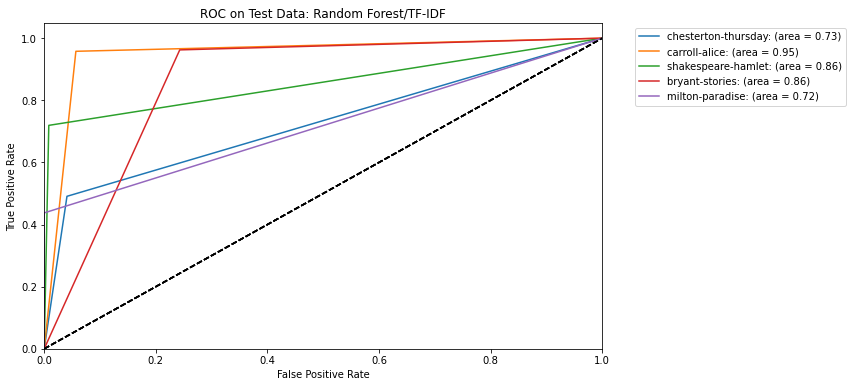

In [54]:
plot_ROC(y_test,predictions,': Random Forest/TF-IDF')

### Summary of results from Tf-idf/Random Forest 
* Grid search performed has shown that the optimal hyper parameter values is using bootstrap and 500 trees 
* From training/CV:
    * For certain CV, 250 trees had better prediction on the test data compared to 500 trees.
    * This decrease in test performance for certain data split indicates early signs of overfitting.
    * The learning curve also shows more standard deviation with 500 trees compared to 250 trees. This indicates that 500 trees may have less bias but more variance.
    * We speculate that the optimal number of trees should be in between 250-500 trees.
    * The visualized Learning Curve graph also justifies how the model with the optimal number of trees is well-fit for the   given data.
* The ROC Curve: The areas covered by the ROC plot for each class show that the model was better at classifying some writing styles than the others. The average area covered by the ROC curve is 0.87. This shows that the model is not ideal for classification.
* For the actual testing data: there was sparse value thorughout the confusion matrix and not just on the diagonal, and our prediction can predict the label correctly 71% of the time for (new) test data. 
* Unfortunately, after thoroughly assessing the model based on the above factors, we would not recommend this classifier at this accuracy level.
 

-----------------------------------------------------------------------------------------------------------

# Modelling 
# Naive-Bayes Algorithm with TF-IDF
Naive Bayes Classifier uses probabilities to predict the outcome. The name basically implies that the outcome of one feature is independent of occurences of other features.
### Hyper parameter tuning using grid-search with 10 fold cross validation
* we are performing hyper parameter tuning on:
 * var_smoothing 
    * var_smoothing or laplace smoothing is used to solve the problem of occurence of zeroes that result from frequency based probabilities. The zeroes appear when a combination of feature and a class variable is not available.
* We used a grid search to identify the best combination of these parameters 

In [55]:
nb_classifier = GaussianNB()
params_NB = {'var_smoothing': np.logspace(0,-9, num=10)}
   
grid_searchNB=GridSearchCV(nb_classifier,params_NB,cv=10,return_train_score=True,scoring='accuracy')
grid_searchNB.fit(tfidf_train_data.todense(),y_train)

GridSearchCV(cv=10, estimator=GaussianNB(),
             param_grid={'var_smoothing': array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06, 1.e-07,
       1.e-08, 1.e-09])},
             return_train_score=True, scoring='accuracy')

## Grid search and cross validation for TF-IDF and Naive Bayes Algorithm
 Note We can also use **best_params_** with the grid search object to yield the optimal result

In [56]:
results=gridsearchResultstoDf(grid_searchNB)
results.sort_values(by='mean test score')
results[results['mean test score']==results['mean test score'].max()].iloc[0]['param']

{'var_smoothing': 0.01}

## Learning Curve:
### Model Bias and Variance  
* From the following learning curve graphs:
* Initially, with increase in smoothing parameter, we see an increase in averagetest performance, this means the model is decreasing both bias and variance
* However the mean test score seems to drop off significantly was we increase the parameter past 0.01 (even though the training score is the same). 
* This means that using a var_smoothing value greater than 0.01 will do great on training data but bad in test data. 
* Therefore, we can conclude that using higher than 0.01 of var_smoothing value will lead to overfitting, where the model will have low bias but high variance. 
* The optimal parameter value is therefore 0.01


Text(0.5, 1.0, 'Learning Curves from Cross validation ')

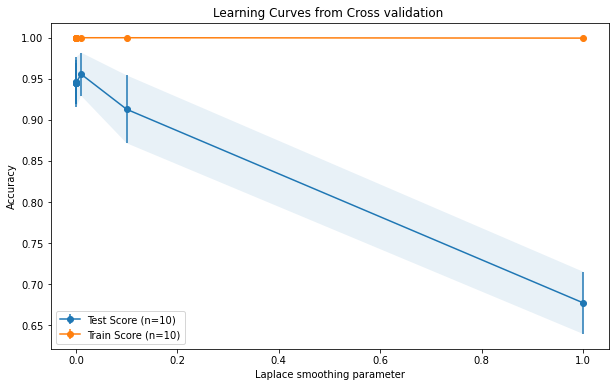

In [57]:
temp_nb_cv_results=results
temp_nb_cv_results[['var_smoothing']]=results['param'].apply(pd.Series)
temp_nb_cv_results['test sdv']=results[['CV1 test loss','CV2 test loss','CV3 test loss','CV4 test loss','CV5 test loss','CV6 test loss','CV7 test loss','CV9 test loss','CV10 test loss']].std(axis=1)
temp_nb_cv_results['train sdv']=results[['CV1 train loss','CV2 train loss','CV3 train loss','CV4 train loss','CV5 trainloss','CV6 train loss','CV7 train loss','CV9 train loss','CV10 train loss']].std(axis=1)

results.sort_values(by='var_smoothing',inplace=True)
bootstrapTrue_cv_results=temp_nb_cv_results
plt.figure(figsize=(10,6))
plt.fill_between(temp_nb_cv_results['var_smoothing'],temp_nb_cv_results['mean test score']-temp_nb_cv_results['test sdv'],temp_nb_cv_results['mean test score']+temp_nb_cv_results['test sdv'],alpha=0.1)
plt.fill_between(temp_nb_cv_results['var_smoothing'],temp_nb_cv_results['mean train score']-temp_nb_cv_results['train sdv'],temp_nb_cv_results['mean train score']+temp_nb_cv_results['train sdv'],alpha=0.1)
plt.errorbar(temp_nb_cv_results['var_smoothing'],temp_nb_cv_results['mean test score'],temp_nb_cv_results['test sdv'],label='Test Score (n=10)',fmt='-o')
plt.errorbar(temp_nb_cv_results['var_smoothing'],temp_nb_cv_results['mean train score'],temp_nb_cv_results['train sdv'],label='Train Score (n=10)',fmt='-o')
plt.ylabel('Accuracy')
plt.xlabel('Laplace smoothing parameter')
plt.legend()
plt.title('Learning Curves from Cross validation ')

# Scoring:
Implementing the Tf-idf and Naive Bayes algorithm with the optimal hyper parameters (smoothing=0.01) determined from grid search. We train the model using the vectorized X train data and Y train. We predict the results using the vectorized X test data.
#### This tuned model will be used to predict the true test/holdout data.


In [58]:
clf=GaussianNB (var_smoothing= 0.01)
clf.fit(tfidf_train_data.todense(),y_train)
predictions= clf.predict(tfidf_test_data.todense())    


# Testing Result 
### Evaluation using confusion matrix and classification report for the TF-IDF/Naive Bayes(var_smoothing=0.01) classifier's performance. 

##### Confusion matrix have most of the values in the diagonal, this is good. 

In [59]:
 print(confusion_matrix(y_test,predictions)) 
    

[[47  1  2  3  0]
 [ 5 63  3  0  0]
 [ 1  2 52  0  0]
 [ 0  0  0 64  0]
 [ 0  0  0  0 57]]


##### With an average value of 0.94 this is a pretty good model! 

In [60]:
 print(classification_report(y_test,predictions))

                     precision    recall  f1-score   support

     bryant-stories       0.89      0.89      0.89        53
      carroll-alice       0.95      0.89      0.92        71
chesterton-thursday       0.91      0.95      0.93        55
    milton-paradise       0.96      1.00      0.98        64
 shakespeare-hamlet       1.00      1.00      1.00        57

           accuracy                           0.94       300
          macro avg       0.94      0.94      0.94       300
       weighted avg       0.94      0.94      0.94       300



## ROC Curve:
### The areas covered in the below plot for each class show that the model can properly classify 16th century classics such as Shakespeare-Hamlet and Milton-paradise (area of 0.99-1) while it could misclassify modern writing styles, similar to TF-IDF SVC.

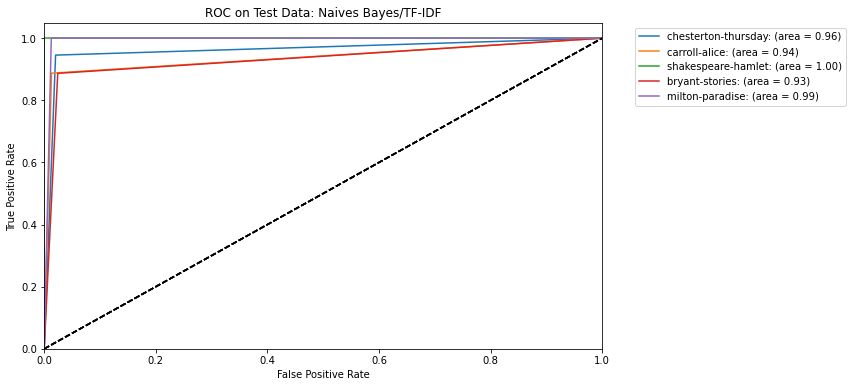

In [61]:
plot_ROC(y_test,predictions,': Naives Bayes/TF-IDF')

 ### Summary of results from Tf-idf/Naives-Bayes
* Grid search performed has shown that the optimal hyper parameters values is using var_smoothing of 0.01
* From training/CV and learning curve: Increasing the var smoothing decreased model bias and variance until 0.01, after that, the model bias will decrease but the variance will increase.  
* For the actual testing data: For the confusion matrix majority of the data was on the diagonal, and our model can predict the label correctly 94% of the time for new data.
* The ROC Curve: The areas covered by the ROC plot for each class show that the model was better at classifying 16th century classics than the modern writing styles. The average area covered by the ROC curve is 0.96.  
* Although we've seen better accuracy with SVC, this is also a great classifer!
 

------------------------------------------------------------------------------------------------------------------------------

## Explore these three algorithms with Bag of words feature selection 


# Feature Engineering : Using bag of words to transform our X (Passages) into vectors
### Bag of words:
Bag of words is a form of vectorization process for extracting features from the textual data. Like Tf-idf, this is another step of feature processing, but it does not take into account how often the words will appear across different documents. 
The term 'bag' implies that the order of the words appearing in the document is ignored. The model is only concerned with whether the word is present in a document, not with the location of the word in the document.

####  We have already performed train/test split previously. We will directly apply the BoW feature transformation on both of our x_train and x_test data.

In [62]:
vec = CountVectorizer(binary=True)
countvect_train_data = vec.fit_transform(x_train) 
countvect_test_data = vec.transform(x_test)

# Modelling 
## SVC Algorithm - Bag of words
### Hyper parameter tuning using grid-search with 10 fold cross validation
* hyper parameter tuning on:
 * C
 * type of loss 
* Process similar to SVC/Tf-idf 

In [63]:
SVCparameters = {
  'C':[1,5,10],
  'loss': ['squared_hinge','hinge'], 
  }
clf=LinearSVC(random_state=101) 
grid_search=GridSearchCV(clf,SVCparameters,cv=10,return_train_score=True,scoring='accuracy')
grid_search.fit(countvect_train_data,y_train)

GridSearchCV(cv=10, estimator=LinearSVC(random_state=101),
             param_grid={'C': [1, 5, 10], 'loss': ['squared_hinge', 'hinge']},
             return_train_score=True, scoring='accuracy')

#### Grid search results returned for  Bag of words and SVC algorithm.


In [64]:
results=gridsearchResultstoDf(grid_search)
results.sort_values(by='mean test score')
results[results['mean test score']==results['mean test score'].max()].iloc[0]['param']

{'C': 1, 'loss': 'squared_hinge'}

### Bias and Variance Tradeoff 
### Learning curve for different values of parameter C at using Hinge Loss
* From the plotted graph, we can see that the model is neither an overfit nor an underfit for the changes in the parameter.
* The average train and test scores are almost overlapping for all ranges of C and there is very little standard deviation of scores (which is not visible in the graph). 
* The consistent high average score across 10 CV along with very low std means that using any value of C in a range of [0-10], with hingeloss, in a SVM method will yield a model with low bias and low variance. 
*All models have good bias and variance.


Text(0.5, 1.0, 'Learning Curves from Cross validation of SVC /Bag of words/hinge loss')

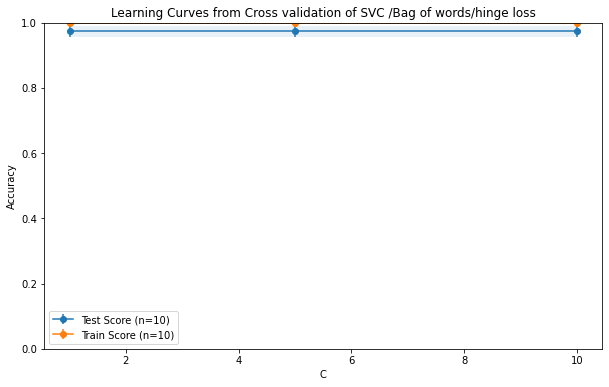

In [65]:
temp_SVC_cv_results=results
temp_SVC_cv_results[['C','loss']]=temp_SVC_cv_results['param'].apply(pd.Series)
temp_SVC_cv_results['test sdv']=temp_SVC_cv_results[['CV1 test loss','CV2 test loss','CV3 test loss','CV4 test loss','CV5 test loss','CV6 test loss','CV7 test loss','CV9 test loss','CV10 test loss']].std(axis=1)
temp_SVC_cv_results['train sdv']=temp_SVC_cv_results[['CV1 train loss','CV2 train loss','CV3 train loss','CV4 train loss','CV5 trainloss','CV6 train loss','CV7 train loss','CV9 train loss','CV10 train loss']].std(axis=1)
temp_SVC_cv_results['loss']=='hinge'
plt.figure(figsize=(10,6)) 
param='C'
results.copy().sort_values(by=param,inplace=True)
resultsSVC=results[results['loss']=='hinge']
plt.fill_between(resultsSVC[param],resultsSVC['mean test score']-resultsSVC['test sdv'],resultsSVC['mean test score']+resultsSVC['test sdv'],alpha=0.1)
plt.fill_between(resultsSVC[param],resultsSVC['mean train score']-resultsSVC['train sdv'],resultsSVC['mean train score']+resultsSVC['train sdv'],alpha=0.1)
plt.errorbar(resultsSVC[param],resultsSVC['mean test score'],resultsSVC['test sdv'],label='Test Score (n=10)',fmt='-o')
plt.errorbar(resultsSVC[param],resultsSVC['mean train score'],resultsSVC['train sdv'],label='Train Score (n=10)',fmt='-o')
plt.ylabel('Accuracy')
plt.xlabel(param)
plt.legend()
plt.ylim(0,1)
plt.title('Learning Curves from Cross validation of SVC /Bag of words/hinge loss')

### Learning curve for different values of parameter C at using Squared Hinge Loss
* Results consistent with hinge loss 
* Using different loss does not impact model performance 

Text(0.5, 1.0, 'Learning Curves from Cross validation of SVC /Bag of words/squared hinge loss')

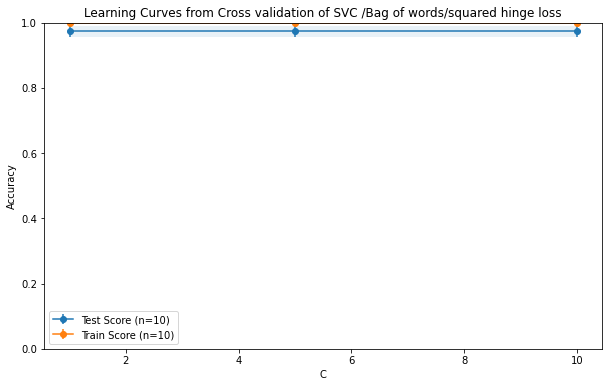

In [66]:
temp_SVC_cv_results=results
temp_SVC_cv_results[['C','loss']]=temp_SVC_cv_results['param'].apply(pd.Series)
temp_SVC_cv_results['test sdv']=temp_SVC_cv_results[['CV1 test loss','CV2 test loss','CV3 test loss','CV4 test loss','CV5 test loss','CV6 test loss','CV7 test loss','CV9 test loss','CV10 test loss']].std(axis=1)
temp_SVC_cv_results['train sdv']=temp_SVC_cv_results[['CV1 train loss','CV2 train loss','CV3 train loss','CV4 train loss','CV5 trainloss','CV6 train loss','CV7 train loss','CV9 train loss','CV10 train loss']].std(axis=1)
plt.figure(figsize=(10,6)) 
param='C'
results.copy().sort_values(by=param,inplace=True)
resultsSVC=results[results['loss']=='squared_hinge']
plt.fill_between(resultsSVC[param],resultsSVC['mean test score']-resultsSVC['test sdv'],resultsSVC['mean test score']+resultsSVC['test sdv'],alpha=0.1)
plt.fill_between(resultsSVC[param],resultsSVC['mean train score']-resultsSVC['train sdv'],resultsSVC['mean train score']+resultsSVC['train sdv'],alpha=0.1)
plt.errorbar(resultsSVC[param],resultsSVC['mean test score'],resultsSVC['test sdv'],label='Test Score (n=10)',fmt='-o')
plt.errorbar(resultsSVC[param],resultsSVC['mean train score'],resultsSVC['train sdv'],label='Train Score (n=10)',fmt='-o')
plt.ylabel('Accuracy')
plt.xlabel(param)
plt.legend()
plt.ylim(0,1)
plt.title('Learning Curves from Cross validation of SVC /Bag of words/squared hinge loss')

# Scoring:  Bag of word/SVC( C=1,loss='squared_hinge')
#### This tuned model will be trained on the training set and used to predict the true test/holdout data

In [67]:
clf=LinearSVC(C=1,loss='squared_hinge')
clf.fit(countvect_train_data,y_train)
predictions= clf.predict(countvect_test_data)    

# Testing Results 
#### Confusion matrix/ Classification report of the classifier's performance.
The confusion matrix has mostly a diagonal matrix and has a really good performance. 

In [68]:
 print(confusion_matrix(y_test,predictions))

[[47  2  3  1  0]
 [ 0 71  0  0  0]
 [ 0  0 55  0  0]
 [ 0  0  0 64  0]
 [ 0  0  0  1 56]]


The overall classifier has an average accuracy if 0.98 value. This is good!

In [69]:
  print(classification_report(y_test,predictions))

                     precision    recall  f1-score   support

     bryant-stories       1.00      0.89      0.94        53
      carroll-alice       0.97      1.00      0.99        71
chesterton-thursday       0.95      1.00      0.97        55
    milton-paradise       0.97      1.00      0.98        64
 shakespeare-hamlet       1.00      0.98      0.99        57

           accuracy                           0.98       300
          macro avg       0.98      0.97      0.98       300
       weighted avg       0.98      0.98      0.98       300



## ROC Curve:
The areas covered by the given ROC plot is based on true and false postive rates for each class. This graphshow that the model can better classify carroll-alice and milton-paradise while it is poor at classifying bryant-stories.

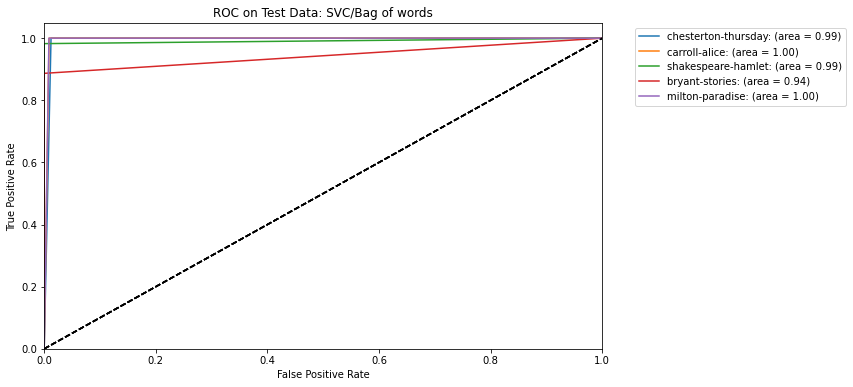

In [70]:
plot_ROC(y_test,predictions,': SVC/Bag of words')

### Summary of results from Bag of words/SVC
* Grid search performed has shown that the optimal hyper parameters values is C=1 and loss ='squared_hinge'.
* From training/CV: There does not seem to be any overfitting from the cross validation data (test accuracy and train accuracy very similar during cross validation).All models have good bias and variance.
* The visualized Learning Curve graph also justifies how the model is well-fit for the data, given that the mean test and train scores are almost overlapping.
* The ROC Curve: The areas covered by the ROC plot for each class show that the model was better at classifying some writing styles than the others. The average area covered by the ROC curve is 0.98. This reinforces that the model is good for classification.
* For the actual testing data: majority of the values of the confusion matrix is in the diagonal, and our prediction can predict the label correctly 98% of the time for new data ( As opposed to 99% with Tf-dif/SVC).
* Bag of word/SVC generated almost the same prediction results as Tf-idf/SVC with only 1% less! Tf-idf may have improved the testing data slightly through getting rid of common/Non-discriminating features(words). 

----------------------------------------------------------------------------------------------------------

# KNN /Bag of Words
# Modelling

 
### Hyper parameter tuning using grid-search with 10 fold cross validation
* We are performing the hyper parameter tuning on:
 * type of distance monitoring (p): 
    * p=1 uses manhattan_distance
    * p=2 uses euclidean_distance 
 * weights: 
    * uniform ( all points will be given equal weights)
    * distance (points will be given weights that are inverse to the distance)
 


In [71]:
KNNparameters = {
  'p':[1,2],
  'weights': ['uniform','distance'], 
  }
clf= KNeighborsClassifier(n_neighbors=3) 
grid_search=GridSearchCV(clf,KNNparameters,cv=10,return_train_score=True,scoring='accuracy')
grid_search.fit(tfidf_train_data,y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(n_neighbors=3),
             param_grid={'p': [1, 2], 'weights': ['uniform', 'distance']},
             return_train_score=True, scoring='accuracy')

#### Grid search results returned for  Bag of Words and KNN algorithm. 

Instead of showing the detailed analysis of grid search results to select best parameters (as shown with SVC and Bag of Words), we can also use best_params_ with the grid search object to yield the same result.

In [72]:
grid_search.best_params_

{'p': 2, 'weights': 'distance'}

In [73]:
results=gridsearchResultstoDf(grid_search)

results.sort_values(by='mean test score')

temp_tree_cv_results=results
temp_tree_cv_results[['uniform','distance']]=temp_tree_cv_results['param'].apply(pd.Series)
temp_tree_cv_results['test sdv']=temp_tree_cv_results[['CV1 test loss','CV2 test loss','CV3 test loss','CV4 test loss','CV5 test loss','CV6 test loss','CV7 test loss','CV9 test loss','CV10 test loss']].std(axis=1)
temp_tree_cv_results['train sdv']=temp_tree_cv_results[['CV1 train loss','CV2 train loss','CV3 train loss','CV4 train loss','CV5 trainloss','CV6 train loss','CV7 train loss','CV9 train loss','CV10 train loss']].std(axis=1)

### Model Bias and Variance 
* For manhattan(p=1) distance, the average mean of cross-validation test data have low accuracy (0.5) for both uniform and inverse-distance weights. But for different reasons. Uniform weights have low average training accuracy and test accuracy, indicating underfitting (high bias and low variance). While inverse-distance weights have average training accuracy much higher, it also has low test accuracy, which indicates that the model is overfitting (low bias and high variance).
* For euclidean (p=2) distance, both uniform and inverse-distance weights have high training accuracy and high test accuracy. These indicates good models that are able to generalize to new data (in cross validation). Therefore, euclidian distance should be used with either random or inverse-distance. 
* These results are consistent with Tf-idf with KNN

(0.0, 1.0)

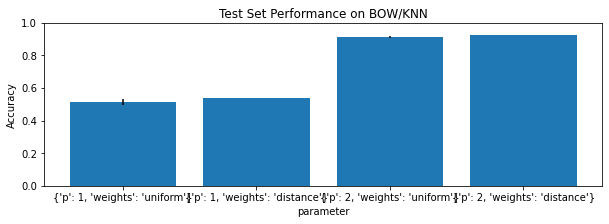

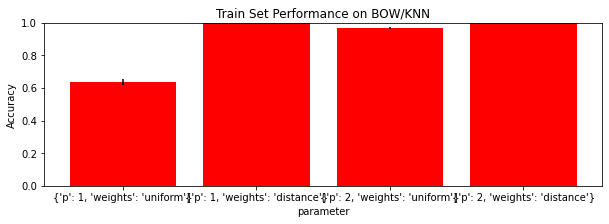

In [74]:
temp_tree_cv_results['param'].astype(str)

fig=plt.figure(figsize=(10,3))
plt.title('Test Set Performance on BOW/KNN')
plt.bar(temp_tree_cv_results['param'].astype(str),temp_tree_cv_results['mean test score'],yerr=temp_tree_cv_results['train sdv'])
plt.xlabel('parameter')
plt.ylabel('Accuracy')
plt.ylim(0,1)
  
fig=plt.figure(figsize=(10,3))
plt.title('Train Set Performance on BOW/KNN')
plt.bar(temp_tree_cv_results['param'].astype(str),temp_tree_cv_results['mean train score'],yerr=temp_tree_cv_results['train sdv'],color='red')
plt.rc('font', size=10) 
plt.xlabel('parameter')
plt.ylabel('Accuracy')
plt.ylim(0,1)

# Scoring: Bag of words/KNN

Implementing the Bag of words and KNN with the optimal hyper parameters determined from grid search. We train the model using the vectorized X train data and Y train. We predict the results using the vectorized X test data. This tuned model will now be predicted using the true test/holdout data.

In [75]:
clf=KNeighborsClassifier( p=2,weights='distance')
clf.fit(tfidf_train_data,y_train)
predictions= clf.predict(tfidf_test_data)    

# Testing Results : 
#### Confusion matrix and Classification report for the Bow/KNN(euclidean_distance, distance-weights) classifier's performance. 

 #### The confusion matrix here shows fairly good results. 
There are a lot of wrong values specifically in the columns 2 of row 3. 
This means that the classifier is often mislabelling chesteron-thursday into carroll-alice. 

In [76]:
 print(confusion_matrix(y_test,predictions)) 
    

[[50  1  2  0  0]
 [ 0 71  0  0  0]
 [ 2 11 42  0  0]
 [ 2  1  2 59  0]
 [ 0  0  0  0 57]]


#### The classification report shows an accuracy of 0.93. This is a pretty good classifier!
This result is very similar to running KNN with tf-idf. 

In [77]:
  print(classification_report(y_test,predictions))

                     precision    recall  f1-score   support

     bryant-stories       0.93      0.94      0.93        53
      carroll-alice       0.85      1.00      0.92        71
chesterton-thursday       0.91      0.76      0.83        55
    milton-paradise       1.00      0.92      0.96        64
 shakespeare-hamlet       1.00      1.00      1.00        57

           accuracy                           0.93       300
          macro avg       0.94      0.93      0.93       300
       weighted avg       0.93      0.93      0.93       300



 ### ROC Curve:
 The following ROC demonstrates that area under the curve are all fairly high.
 Overall these results are good!
 

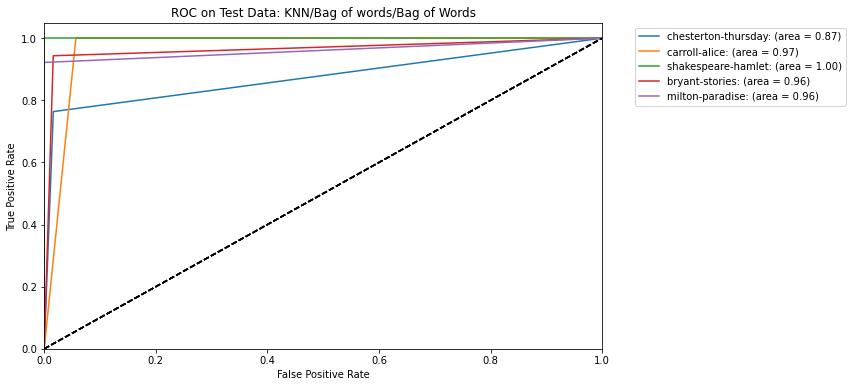

In [78]:
plot_ROC(y_test,predictions,': KNN/Bag of words/Bag of Words')

---------------------------------------------------------------------------------------------------------------

# Modelling 
## Random Forest Algorithm- Bag of word 
### Hyper parameter tuning using grid-search with 10 fold cross validation
* hyper parameter tuning on:
 * whether to use bootstrap
 * number of trees  (5-500)
* Note that we did not investigate other parameters such as tree depth or number of split. We used the default values of 100 and 2 for those. 

#### Grid search results returned for Bag of words and Random Forest algorithm.


In [79]:
  RFparameters = {
  'bootstrap':['True','False'],
  'n_estimators': [5,10,50,100,250,500]
  } 
grid_searchRF=GridSearchCV(RandomForestClassifier(random_state=101),RFparameters,cv=10,return_train_score=True,scoring='accuracy')
grid_searchRF.fit(countvect_train_data,y_train)
results=gridsearchResultstoDf(grid_searchRF)

In [80]:
results.sort_values(by='mean test score')
results[results['mean test score']==results['mean test score'].max()].iloc[0]['param']

{'bootstrap': 'True', 'n_estimators': 500}


### Bias and Variance Tradeoff 
### Learning curve for different number of trees for random forest with BoW without bootstrap

* From the following graphs, we can see that the average test score is converging towards the average train score as the n-estimator value reaches 500. 
* For random forest, using BOW signficantly increased performance (both bias and variance) compared to using Tf-idf. This could be due to certain repeating features (such as common words that were taken out in Tf-idf) that the forest can use for discriminatory purposes. 
* Furthermore, unlike the case of Tf-idf, increasing trees not only increased the mean test accuracy (decreased bias) but also did not increase variance (the shaded blue area also decreased with increasing more trees). 
* Here, with increasing trees we see both a decrease in bias and variance, therefore the optimal tree numbers may be greater than 500.


Text(0.5, 1.0, 'Learning Curves from Cross validation (bootstrap=False)')

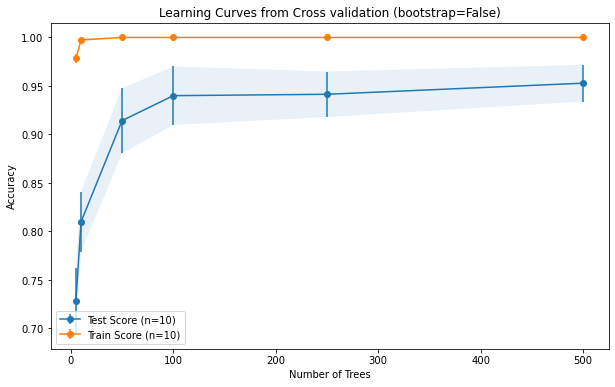

In [81]:
temp_tree_cv_results=results
temp_tree_cv_results[['bootstrap','n_estimators']]=temp_tree_cv_results['param'].apply(pd.Series)
temp_tree_cv_results['test sdv']=temp_tree_cv_results[['CV1 test loss','CV2 test loss','CV3 test loss','CV4 test loss','CV5 test loss','CV6 test loss','CV7 test loss','CV9 test loss','CV10 test loss']].std(axis=1)
temp_tree_cv_results['train sdv']=temp_tree_cv_results[['CV1 train loss','CV2 train loss','CV3 train loss','CV4 train loss','CV5 trainloss','CV6 train loss','CV7 train loss','CV9 train loss','CV10 train loss']].std(axis=1)
fig = plt.figure(num=1,figsize=(10,6))
temp_tree_cv_results.sort_values(by='n_estimators',inplace=True)
bootstrapFalse_cv_results=temp_tree_cv_results[temp_tree_cv_results['bootstrap']=='False']
plt.fill_between(bootstrapFalse_cv_results['n_estimators'],bootstrapFalse_cv_results['mean test score']-bootstrapFalse_cv_results['test sdv'],bootstrapFalse_cv_results['mean test score']+bootstrapFalse_cv_results['test sdv'],alpha=0.1)
plt.fill_between(bootstrapFalse_cv_results['n_estimators'],bootstrapFalse_cv_results['mean train score']-bootstrapFalse_cv_results['train sdv'],bootstrapFalse_cv_results['mean train score']+bootstrapFalse_cv_results['train sdv'],alpha=0.1)
plt.errorbar(temp_tree_cv_results[temp_tree_cv_results['bootstrap']=='False']['n_estimators'],temp_tree_cv_results[temp_tree_cv_results['bootstrap']=='False']['mean test score'],temp_tree_cv_results[temp_tree_cv_results['bootstrap']=='False']['test sdv'],label='Test Score (n=10)',fmt='-o')
plt.errorbar(temp_tree_cv_results[temp_tree_cv_results['bootstrap']=='False']['n_estimators'],temp_tree_cv_results[temp_tree_cv_results['bootstrap']=='False']['mean train score'],temp_tree_cv_results[temp_tree_cv_results['bootstrap']=='False']['train sdv'],label='Train Score (n=10)',fmt='-o')
plt.ylabel('Accuracy')
plt.xlabel('Number of Trees')
plt.legend()
plt.title('Learning Curves from Cross validation (bootstrap=False)')

### Learning curve for different number of trees for random forest with BoW bootstrap
* Similar trend to without bootstrap
* Increasing trees caused both a decrease in bias and variance (no sign of overfitting)
* Therefore the optimal number of trees may be greater than 500

Text(0.5, 1.0, 'Learning Curves from Cross validation (bootstrap=True)')

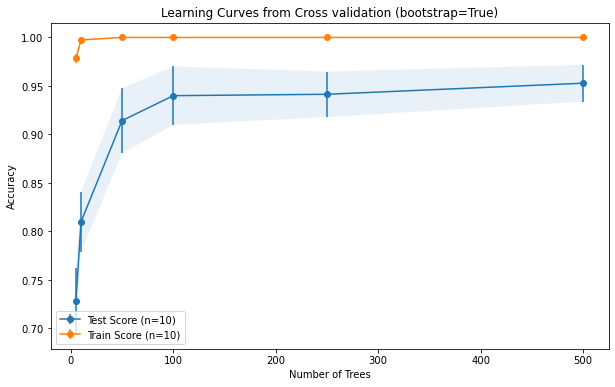

In [82]:
temp_tree_cv_results=results
temp_tree_cv_results[['bootstrap','n_estimators']]=temp_tree_cv_results['param'].apply(pd.Series)
temp_tree_cv_results['test sdv']=temp_tree_cv_results[['CV1 test loss','CV2 test loss','CV3 test loss','CV4 test loss','CV5 test loss','CV6 test loss','CV7 test loss','CV9 test loss','CV10 test loss']].std(axis=1)
temp_tree_cv_results['train sdv']=temp_tree_cv_results[['CV1 train loss','CV2 train loss','CV3 train loss','CV4 train loss','CV5 trainloss','CV6 train loss','CV7 train loss','CV9 train loss','CV10 train loss']].std(axis=1)
fig = plt.figure(num=1,figsize=(10,6))
temp_tree_cv_results.sort_values(by='n_estimators',inplace=True)
bootstrapFalse_cv_results=temp_tree_cv_results[temp_tree_cv_results['bootstrap']=='True']
plt.fill_between(bootstrapFalse_cv_results['n_estimators'],bootstrapFalse_cv_results['mean test score']-bootstrapFalse_cv_results['test sdv'],bootstrapFalse_cv_results['mean test score']+bootstrapFalse_cv_results['test sdv'],alpha=0.1)
plt.fill_between(bootstrapFalse_cv_results['n_estimators'],bootstrapFalse_cv_results['mean train score']-bootstrapFalse_cv_results['train sdv'],bootstrapFalse_cv_results['mean train score']+bootstrapFalse_cv_results['train sdv'],alpha=0.1)
plt.errorbar(temp_tree_cv_results[temp_tree_cv_results['bootstrap']=='False']['n_estimators'],temp_tree_cv_results[temp_tree_cv_results['bootstrap']=='False']['mean test score'],temp_tree_cv_results[temp_tree_cv_results['bootstrap']=='False']['test sdv'],label='Test Score (n=10)',fmt='-o')
plt.errorbar(temp_tree_cv_results[temp_tree_cv_results['bootstrap']=='False']['n_estimators'],temp_tree_cv_results[temp_tree_cv_results['bootstrap']=='False']['mean train score'],temp_tree_cv_results[temp_tree_cv_results['bootstrap']=='False']['train sdv'],label='Train Score (n=10)',fmt='-o')
plt.ylabel('Accuracy')
plt.xlabel('Number of Trees')
plt.legend()
plt.title('Learning Curves from Cross validation (bootstrap=True)')

# Scoring:
### Using the optimal parameters from cross validation for prediction. We train the model using the vectorized X train data and Y train. We predict the results using the vectorized X test data.
#### This tuned model will be used to predict the true test/holdout data.


In [83]:
clf=RandomForestClassifier(bootstrap=True,n_estimators=500)
clf.fit(countvect_train_data.todense(),y_train)
predictions= clf.predict(countvect_test_data.todense())    


# Testing Results 
#### Confusion matrix of the Bag of words/Random Forest ( trees=500, bootstrapping) classifier's performance.
Most of the numbers are on the diagonal axis compared to Tf-idf with random forest, showing that it performs a lot better than the model was preprocessed with Tf-idf. 

In [84]:
 print(confusion_matrix(y_test,predictions)) 
    

[[46  1  1  4  1]
 [ 0 71  0  0  0]
 [ 2  0 53  0  0]
 [ 1  0  1 62  0]
 [ 0  0  0  1 56]]


### Classification Report
The classification report shows that a high accuracy of 0.96 on the test data! 
Bag of words with Random Forest has a much better performance than with Tf-idf, where it previously scored an accuracy of 0.71.

In [103]:
  print(classification_report(y_test,predictions))

                     precision    recall  f1-score   support

     bryant-stories       0.39      0.55      0.46        53
      carroll-alice       0.69      0.62      0.65        71
chesterton-thursday       0.42      0.40      0.41        55
    milton-paradise       0.61      0.53      0.57        64
 shakespeare-hamlet       0.57      0.54      0.56        57

           accuracy                           0.53       300
          macro avg       0.54      0.53      0.53       300
       weighted avg       0.55      0.53      0.54       300



## ROC Curve:
The areas covered by the given ROC plot is based on true and false postive rates for each class.
This show that the model can best classify carroll-alice. All books have are >0.9 which is good!

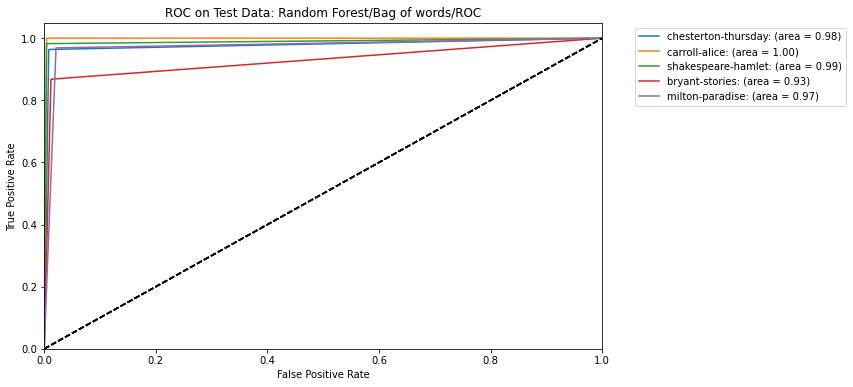

In [86]:
plot_ROC(y_test,predictions,': Random Forest/Bag of words/ROC')

 ### Summary of results from Bag of words/ Random Forest
* Grid search performed has shown that the optimal hyper parameters values is using 500 trees and bootstrap
* For random forest, using BOW signficantly increased performance (both bias and variance) compared to using Tf-idf on the cross validation set for all trees. urthermore, unlike the case of Tf-idf, increasing trees not only decrased bias (increased mean accuracy), but also did not increased variance. Therefore the optimal tree numbers may be greater than 500.
* For the actual testing data: For the confusion matrix majority of the data was on the diagonal, and our prediction can predict the label correctly 94% of the time for new data. 
* The ROC Curve: The areas covered by the ROC plot for each class show that the model can classify carroll-alice the best. The average area covered by the ROC curve is 0.97. This shows that the model is pretty good for classification.
* Bag-of-word with Random forest has resulted significantly higher results compared to Tf-idf with Random Forest (94% Vs 71% accuracy). In this case, Bag of words is a better feature preprocessing method with Random Forest.
 

----------------------------------------------------------------------------------------

# Modelling 
## Naive-Bayes Algorithm with Bag of words
### Hyper parameter tuning and cross validation 
* hyper parameter tuning on:
 * var_smoothing 


In [87]:
nb_classifier = GaussianNB()
params_NB = {'var_smoothing': np.logspace(0,-9, num=10)}
   
grid_searchNB=GridSearchCV(nb_classifier,params_NB,cv=10,return_train_score=True,scoring='accuracy')
grid_searchNB.fit(countvect_train_data.todense(),y_train)

GridSearchCV(cv=10, estimator=GaussianNB(),
             param_grid={'var_smoothing': array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06, 1.e-07,
       1.e-08, 1.e-09])},
             return_train_score=True, scoring='accuracy')

## Grid search and cross validation for BoW and Naive Bayes Algorithm
 Note We can also use **best_params_** with the grid search object to yield the optimal result


## Learning Curve:
### Model Bias and Variance  
* From the following learning curve graphs:
* Initially, with increase in smoothing parameter, we see an increase in average test performance, this means the model is decreasing both bias and variance
* However the mean test score seems to drop off significantly was we increase the parameter past 0.001 (even though the training score is the same). 
* This means that using a var_smoothing value greater than 0.001 will do great on training data but bad in test data. 
* Therefore, we can conclude that using higher than 0.001 of var_smoothing value will lead to overfitting, where the model will have low bias but high variance. 
* The optimal parameter value is therefore 0.001
* These results are similar to nv with Tf-idf except the optimal is 0.001 ( instead of 0.01)


In [88]:
results=gridsearchResultstoDf(grid_searchNB)
results.sort_values(by='mean test score')
results[results['mean test score']==results['mean test score'].max()].iloc[0]['param']

{'var_smoothing': 0.001}

Text(0.5, 1.0, 'Learning Curves from Cross validation ')

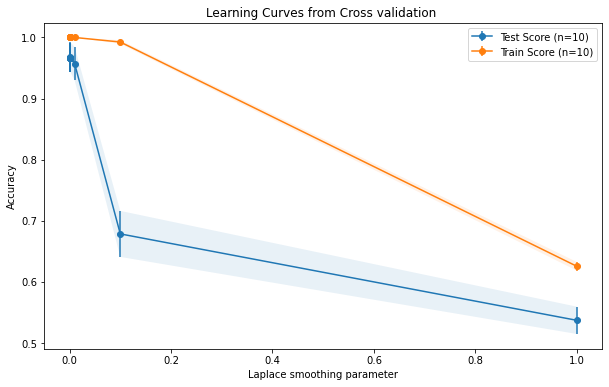

In [89]:
temp_nb_cv_results=results
temp_nb_cv_results[['var_smoothing']]=results['param'].apply(pd.Series)
temp_nb_cv_results['test sdv']=results[['CV1 test loss','CV2 test loss','CV3 test loss','CV4 test loss','CV5 test loss','CV6 test loss','CV7 test loss','CV9 test loss','CV10 test loss']].std(axis=1)
temp_nb_cv_results['train sdv']=results[['CV1 train loss','CV2 train loss','CV3 train loss','CV4 train loss','CV5 trainloss','CV6 train loss','CV7 train loss','CV9 train loss','CV10 train loss']].std(axis=1)

results.sort_values(by='var_smoothing',inplace=True)
bootstrapTrue_cv_results=temp_nb_cv_results
plt.figure(figsize=(10,6))
plt.fill_between(temp_nb_cv_results['var_smoothing'],temp_nb_cv_results['mean test score']-temp_nb_cv_results['test sdv'],temp_nb_cv_results['mean test score']+temp_nb_cv_results['test sdv'],alpha=0.1)
plt.fill_between(temp_nb_cv_results['var_smoothing'],temp_nb_cv_results['mean train score']-temp_nb_cv_results['train sdv'],temp_nb_cv_results['mean train score']+temp_nb_cv_results['train sdv'],alpha=0.1)
plt.errorbar(temp_nb_cv_results['var_smoothing'],temp_nb_cv_results['mean test score'],temp_nb_cv_results['test sdv'],label='Test Score (n=10)',fmt='-o')
plt.errorbar(temp_nb_cv_results['var_smoothing'],temp_nb_cv_results['mean train score'],temp_nb_cv_results['train sdv'],label='Train Score (n=10)',fmt='-o')
plt.ylabel('Accuracy')
plt.xlabel('Laplace smoothing parameter')
plt.legend()
plt.title('Learning Curves from Cross validation ')

# Scoring
### Using the optimal parameters from cross validation for prediction. We train the model using the vectorized X train data and Y train. We predict the results using the vectorized X test data.
#### This tuned model will be used to predict the true test/holdout data.


In [90]:
clf=GaussianNB (var_smoothing= 0.001)
clf.fit(countvect_train_data.todense(),y_train)
predictions= clf.predict(countvect_test_data.todense())    


# Testing Results
#### Confusion matrix of the Bag of words/Naives-Bayes(var_smoothing=0.001) classifier's performance. 
Most of the number is on the diagonal, this is really good!


In [91]:
  print(confusion_matrix(y_test,predictions)) 
    

[[49  1  2  1  0]
 [ 2 68  1  0  0]
 [ 1  0 54  0  0]
 [ 0  0  0 64  0]
 [ 0  0  0  0 57]]


### Classification Report
The classification report shows that a high accuracy of 0.97 on the test data with Bag of words. This is really good!
This number actually increased compared to Tf-idf, which previously had an accuracy of 0.94. 
For similar reasons explained earlier, Bag of words is a better preprocessing step compared to Tf-idf, when paired with naives-bayes model.

In [92]:
print(classification_report(y_test,predictions))

                     precision    recall  f1-score   support

     bryant-stories       0.94      0.92      0.93        53
      carroll-alice       0.99      0.96      0.97        71
chesterton-thursday       0.95      0.98      0.96        55
    milton-paradise       0.98      1.00      0.99        64
 shakespeare-hamlet       1.00      1.00      1.00        57

           accuracy                           0.97       300
          macro avg       0.97      0.97      0.97       300
       weighted avg       0.97      0.97      0.97       300



## ROC Curve
The area under the curve is very high, all greater than 0.95. This means high accuracy in prediction!
Also the model is more biased at classifying 16th century classics such as Shakespeare-Hamlet and Milton-paradise (higher area), while it could misclassify books with modern writing styles.

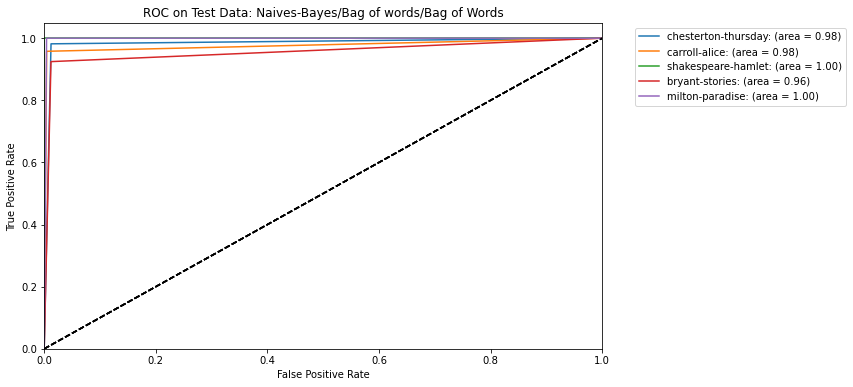

In [93]:
plot_ROC(y_test,predictions,': Naives-Bayes/Bag of words/Bag of Words')

# Error Analysis:
The following list below are the number of misclassified passages from one book to another. 
From here, it seems that the classifier has a difficult time in distinguishing certain passages from chesterton-thursday with bryant-stories,  and carroll-alice with bryant-stories.
This makes sense as they were written in a more similar era, compared to other books such as shakespear-halmiton or milton-paradise.

In [94]:
totalListoferrors=pd.DataFrame(columns=['input','predictions','labels'])
for input, prediction, label in zip(x_test, predictions, y_test):
  if prediction != label:
    listOfErrors=[input,prediction,label]
    totalListoferrors.loc[len(totalListoferrors)]=listOfErrors
totalListoferrors.groupby(by=['predictions','labels']).count()

input
predictions         labels                    
bryant-stories      carroll-alice            2
                    chesterton-thursday      1
carroll-alice       bryant-stories           1
chesterton-thursday bryant-stories           2
                    carroll-alice            1
milton-paradise     bryant-stories           1

In [95]:
totalListoferrors

input          predictions  \
0  leaves are dark crimson   every day they dry a...  chesterton-thursday   
1    first   that it came from a man of massive s...       bryant-stories   
2  room with many little white beds in it   of ch...        carroll-alice   
3  and bade them   with harsh words   go on grind...  chesterton-thursday   
4  love    oh dear   what nonsense i m talking   ...       bryant-stories   
5  she had expected   before she had drunk half t...  chesterton-thursday   
6    leaving alice alone with the gryphon   alice...       bryant-stories   
7  some in the reeds of the black mountainlake   ...      milton-paradise   

                labels  
0       bryant-stories  
1  chesterton-thursday  
2       bryant-stories  
3       bryant-stories  
4        carroll-alice  
5        carroll-alice  
6        carroll-alice  
7       bryant-stories

#### The word cloud visualization of misclassified passages.
Several passages from few books were misclassified under other books.
* Reason 1: In the following visualizations, some of the high frequency words in the passages seem to be stopwords. Since stop words are not unique to a writing style, this could have lead to a misclassification. (We haven't removed stopwords as they could serve as keywords in 16th century classics such as Hamlet)
* Reason 2: The specific passage might have words which are not repeated elsewhere throughout the actual book, but could be present in the predicted book that it is classified as. This could be causing the misclassification.


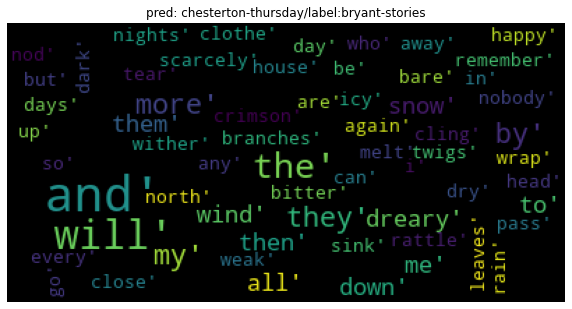

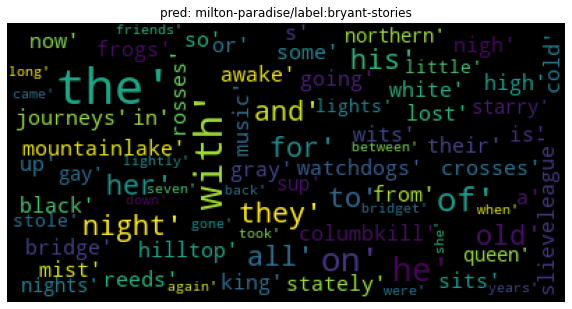

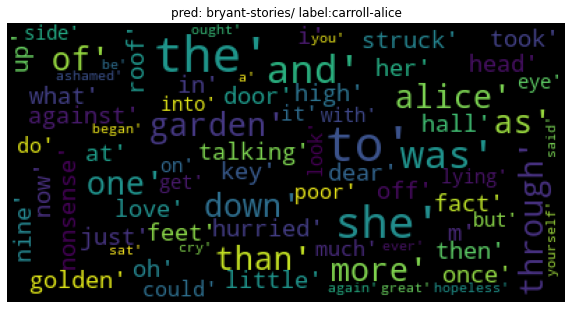

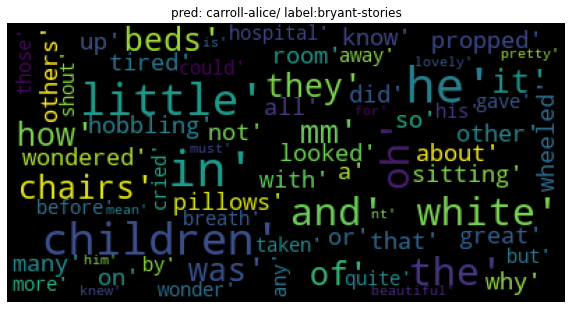

In [96]:
wordc = wordcloud.WordCloud(background_color='black', max_words=100, 
                         max_font_size=35)
wc = wordc.generate(str(nltk.tokenize.word_tokenize(totalListoferrors['input'].iloc[0])))
fig = plt.figure(num=1,figsize=(10,6))
plt.axis('off')
plt.imshow(wc, cmap=None)
plt.title('pred: chesterton-thursday/label:bryant-stories'	)
plt.show()

wc = wordc.generate(str(nltk.tokenize.word_tokenize(totalListoferrors['input'].iloc[7])))
fig = plt.figure(num=1,figsize=(10,6))
plt.axis('off')
plt.imshow(wc, cmap=None)
plt.title('pred: milton-paradise/label:bryant-stories')
plt.show()

wc = wordc.generate(str(nltk.tokenize.word_tokenize(totalListoferrors['input'].iloc[4])))
fig = plt.figure(num=1,figsize=(10,6))
plt.axis('off')
plt.imshow(wc, cmap=None)
plt.title('pred: bryant-stories/ label:carroll-alice')
plt.show()

wc = wordc.generate(str(nltk.tokenize.word_tokenize(totalListoferrors['input'].iloc[2])))
fig = plt.figure(num=1,figsize=(10,6))
plt.axis('off')
plt.imshow(wc, cmap=None)
plt.title('pred: carroll-alice/ label:bryant-stories')
plt.show()

  ### Summary of results from Bag of words /Naives-Bayes
* Grid search performed has shown that the optimal hyper parameters values is using var_smoothing of 0.001
* From training/CV: The test results were good for most of the  smaller var_smoothing parameters. However we recommmend exploring var_smoothing value of equal of below 0.001. 
* Learning curve: The visualized Learning Curve graph also justifies how the model is well-fit for the data at var_smoothing=0.001
* The ROC Curve: The areas covered by the ROC plot for each class show that the model was better at classifying 16th century classics than modern writing styles. The average area covered by the ROC curve is 0.98. This shows that the model is pretty good for classification.
* For the actual testing data: For the confusion matrix majority of the data was on the diagonal, and our prediction can predict the label correctly 97% of the time for new data. 
* Error analysis: The visualizations showing the word clouds show the potential influence of stopwords on the misclassification.
* Bag of words with Naives Bayes has resulted a better value than Tf-idf with Naives Bayes (97% vs 94%)!
 

## Conclusion:
* The algorithm that yielded the highest accuracy on the test data is SVC . 
* Both SVC with Tf-idf and Bag of words feature selection have yielded 99% and 98% accuracy respectively on test data
* For Tf-idf SVC we would recommend using C=3 and squared_hinge loss
* For Bag of words SVC we would reccomend using C=1 and squared_hinge loss


## Case study on using short paragraphs for testing

A function to convert the given passages in the data set into short passages of varying lengths for testing the accuracy of the model. 
 

In [97]:
import re
import nltk

def short_passages(n):
  main_set = []
  regex_pattern = re.compile(r'[A-Za-z0-9]+|^\'\w+')
  counter = 0
  result_set = []
  passage = ''
  for i in range(len(df1)):
    words = nltk.word_tokenize(df1['passage'][i])
    for each_word in words:
      if bool(re.match(regex_pattern, each_word)) == True:
        result_set.append(each_word)
        counter += 1 
      else:
        result_set.append(each_word)   
      if counter >= n:
        passage = " ".join(str(item) for item in result_set)
        counter = 0
        result_set = []
        main_set.append(passage)
        break
    short_passage = pd.Series(main_set)
  short_passage = short_passage.rename('passage')
  df1['short_passages'] = short_passage
  return df1

 ### Function to identify the accuracy scores for different passage lengths

In [98]:
df_words_vs_accuracy=pd.DataFrame(columns={'Passage Length (words)','Number of words vs Accuracy'})
clf=LinearSVC(C=3,loss='squared_hinge')
clf.fit(tfidf_train_data,y_train)
predictions= clf.predict(tfidf_test_data)   
temp=[100,accuracy_score(y_test,predictions)]
df_words_vs_accuracy.loc[len]=temp
passage_length = [90, 80,70,60,50, 40,30,20, 10]

for allX in passage_length:
    dftemp =short_passages(allX)
    
    dftemp['short_passages']=dftemp['short_passages'].apply(return_split)
    dftemp['short_passages']=dftemp['short_passages'].apply(lemmatization)
    x=dftemp['short_passages']
    y=dftemp['bookName'] 

    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,train_size=0.7,random_state=42)
    vec = TfidfVectorizer(binary=True, use_idf=True)
    tfidf_train_data = vec.fit_transform(x_train) 
    tfidf_test_data = vec.transform(x_test)
    clf=LinearSVC(C=3,loss='squared_hinge')
    clf.fit(tfidf_train_data,y_train)
    predictions= clf.predict(tfidf_test_data)
    temp=[]
    temp=[allX,accuracy_score(y_test,predictions)]
    df_words_vs_accuracy.loc[len]=temp

### Plotting a graph for the Passage words vs Test Accuracy
### This plot shows that with increasing words in the passage, we are able to predict the corresponding book with higher accuracy . However, this is a strong classifier, as it is able to classify the test datset of 40 words and greater at an accuracy of 90% and greater.

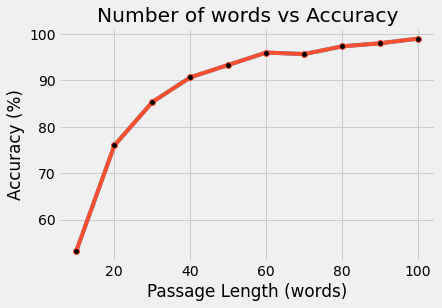

In [102]:

plt.style.use('fivethirtyeight')
 
plt.title('Number of words vs Accuracy')
plt.xlabel('Passage Length (words)')
plt.ylabel('Accuracy (%)')
plt.plot(df_words_vs_accuracy['Passage Length (words)'],df_words_vs_accuracy['Number of words vs Accuracy']*100)
plt.plot(df_words_vs_accuracy['Passage Length (words)'],df_words_vs_accuracy['Number of words vs Accuracy']*100, marker ='o', markerfacecolor='black')
plt.show()

